In [1]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def process_csv(filename, label):
  csv_df = pd.read_csv(filename)
  csv_df['Label'] = label
  print(filename)
  return csv_df

In [3]:
dataset_csv_path = './Dataset/SimulatedCVE' 
csv_file_names = ['dos_ge_dr.csv',
                  'ptbrowsing.csv',
                  'stream.csv'
                  #'dos_stream.csv',
]
df_record = []
for csv_file_name in csv_file_names:
    complete_path = os.path.join(dataset_csv_path, csv_file_name)
    csv_df = process_csv(complete_path, csv_file_name[:-4])
    df_record.append(csv_df)
    
concatenated_df = pd.concat(df_record, ignore_index=True)
concatenated_df    



./Dataset/SimulatedCVE/dos_ge_dr.csv
./Dataset/SimulatedCVE/ptbrowsing.csv
./Dataset/SimulatedCVE/stream.csv


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,Fwd IAT Min,PSH Flag Count,Fwd Packets/s,Bwd Header Length,Label
0,64260,78.840674,502,74608,302.591581,134.687615,5882145,66,521000,42628,26050,137.987825,0,56519,74605,0,9185,0.349158,852560,dos_ge_dr
1,64260,303.408920,64240,19999,303.877612,134.932206,6067875,66,538280,44022,26914,137.837331,0,1638,19998,0,9495,1.345767,880440,dos_ge_dr
2,64260,298.099757,64240,20971,324.400761,138.567478,6251450,66,556900,45409,27845,137.669845,0,1538,20970,0,9905,1.327786,908180,dos_ge_dr
3,64260,241.537172,64240,21118,334.267090,148.840225,5100782,60,419140,33363,20957,152.887390,0,5118,21117,0,8298,0.992376,667260,dos_ge_dr
4,64260,139.985616,64240,20787,512.097618,218.140341,2909881,60,221820,16100,11091,180.737950,0,5118,20782,0,6018,0.533555,322000,dos_ge_dr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,501,1.924983,501,55041,4900.158886,2828.174975,105953,66,33940,1332,1697,79.544294,0,6510,51561,0,1620,0.030832,26640,stream
1451,501,1.964393,501,59510,4807.747306,2762.965660,116901,66,37660,1495,1883,78.194649,0,5009,59508,0,1780,0.031642,29900,stream
1452,64260,0.476142,64240,56983,3554.266542,2013.363636,27132,66,4560,212,228,127.981132,0,7953,56982,0,204,0.004001,4240,stream
1453,501,0.210074,501,51596,529.419710,472.904762,10839,66,360,24,18,451.625000,0,9030,51595,0,16,0.000349,480,stream


In [4]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
flow_df = clean_df(concatenated_df)

dataset shape (1455, 20)
zero variance columns ['Fwd IAT Min'] dropped
shape after removing zero variance columns: (1455, 19)
0 rows dropped
shape after removing nan: (1455, 19)
shape after dropping duplicates: (1430, 19)
columns which have identical values [] dropped
shape after removing identical value columns: (1430, 19)


In [5]:
# flow_df = pd.concat([flow_df[flow_df["Label"] != "dos_ge_dr"], flow_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.2).reset_index(drop=True)])

flow_df['Label'].value_counts()

Label
ptbrowsing    736
stream        469
dos_ge_dr     225
Name: count, dtype: int64

In [6]:
label = flow_df['Label']
normalized_df = flow_df.drop(['Label'], axis = 1)
scaler = StandardScaler()
feature_name = list(normalized_df.columns)
normalized_data = scaler.fit_transform(normalized_df)
normalized_df = pd.DataFrame(normalized_data, columns=feature_name)
normalized_df['Label'] = label.values
normalized_df

,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length,Label
0,2.546919,0.229129,-0.389994,0.006634,-0.667305,-0.708055,3.846169,0.209827,2.839786,3.585221,2.839802,0.072632,-0.04125,0.017356,0.007791,1.088355,0.250887,3.585221,dos_ge_dr
1,2.546919,1.517497,2.664089,-0.063837,-0.666850,-0.707907,3.981814,0.209827,2.952046,3.718544,2.952064,0.070552,-0.04125,-0.053499,-0.062673,1.142995,1.899887,3.718544,dos_ge_dr
2,2.546919,1.487037,2.664089,-0.062582,-0.659597,-0.705707,4.115885,0.209827,3.073012,3.851198,3.073031,0.068238,-0.04125,-0.053628,-0.061419,1.215261,1.870135,3.851198,dos_ge_dr
3,2.546919,1.162533,2.664089,-0.062393,-0.656110,-0.699489,3.275515,-2.354722,2.178049,2.699106,2.178053,0.278539,-0.04125,-0.049006,-0.061229,0.932013,1.315162,2.699106,dos_ge_dr
4,2.546919,0.579923,2.664089,-0.062820,-0.593259,-0.657542,1.675428,-2.354722,0.896151,1.048054,0.896135,0.663425,-0.04125,-0.049006,-0.061661,0.530142,0.555991,1.048054,dos_ge_dr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,-0.392798,-0.212143,-0.390041,-0.018617,0.957616,0.922284,-0.372372,0.209827,-0.324418,-0.364373,-0.324455,-0.735039,-0.04125,-0.047209,-0.021945,-0.245045,-0.275819,-0.364373,stream
1426,-0.392798,-0.211917,-0.390041,-0.012850,0.924955,0.882813,-0.364376,0.209827,-0.300251,-0.348783,-0.300288,-0.753690,-0.04125,-0.049147,-0.011690,-0.216844,-0.274479,-0.348783,stream
1427,2.546919,-0.220455,2.664089,-0.016111,0.481937,0.429087,-0.429937,0.209827,-0.515287,-0.471491,-0.515327,-0.065657,-0.04125,-0.045346,-0.014949,-0.494628,-0.320213,-0.471491,stream
1428,-0.392798,-0.221982,-0.390041,-0.023062,-0.587137,-0.503336,-0.441836,0.209827,-0.542572,-0.489471,-0.542613,4.406998,-0.04125,-0.043955,-0.021901,-0.527765,-0.326256,-0.489471,stream


# 2D-PCA visualization

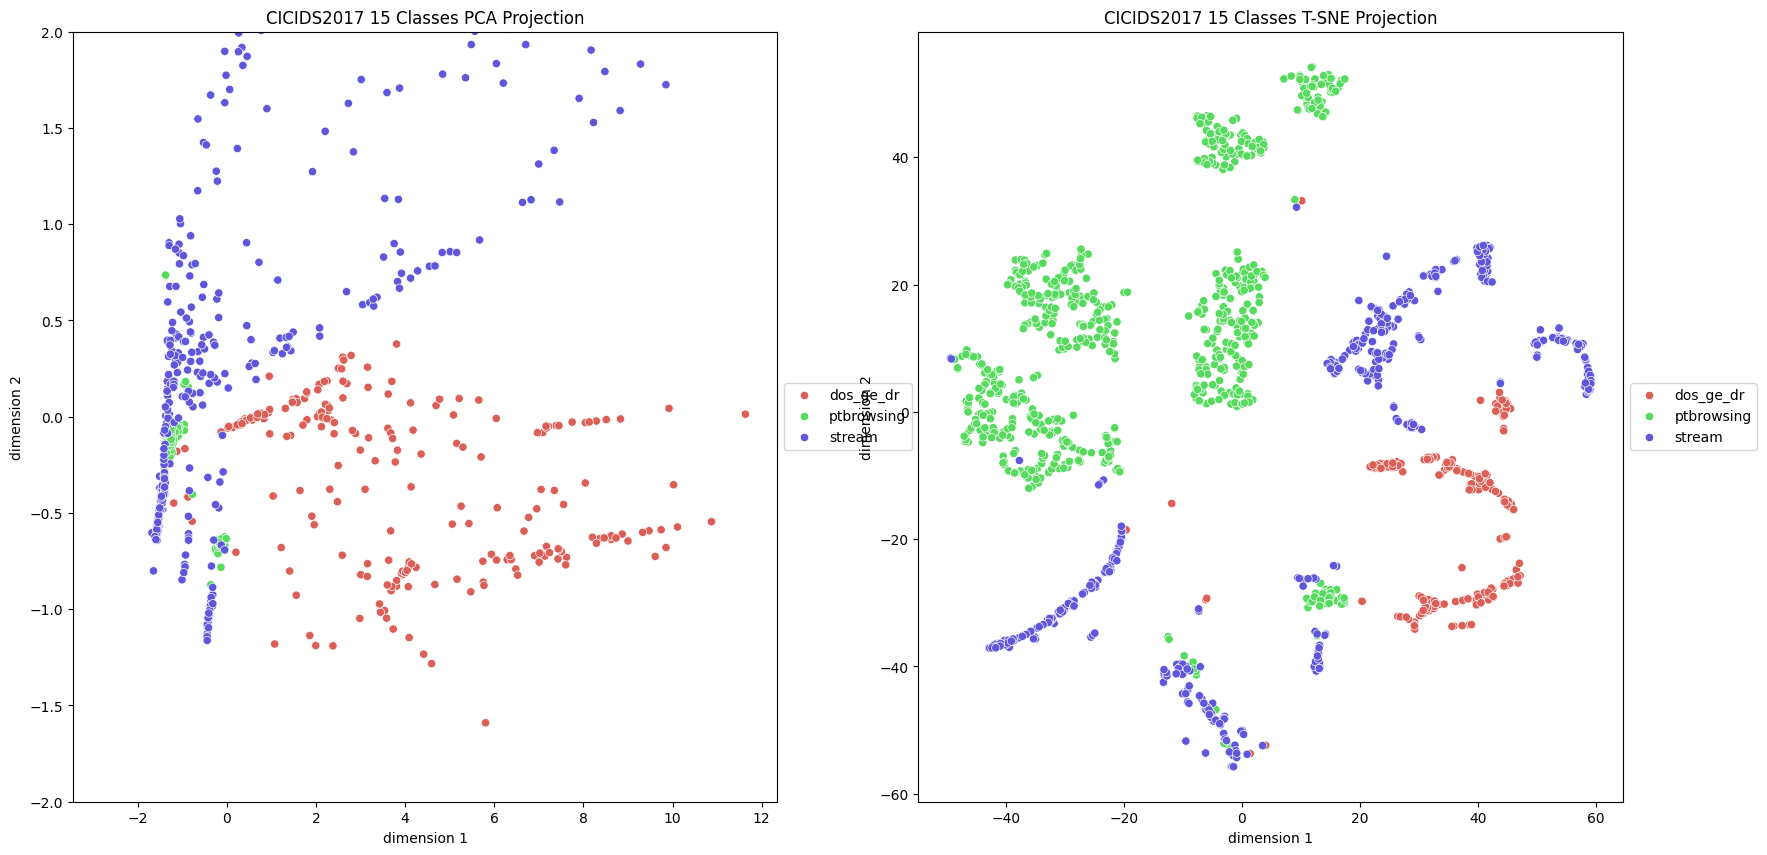

In [7]:
subsample_df = normalized_df
# subsample_df = flow_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)
# subsample_df = pd.concat([subsample_df[subsample_df["Label"] != "dos_ge_dr"], subsample_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.1).reset_index(drop=True)])
X = subsample_df.drop(['Label'], axis=1)
y = subsample_df['Label']

# Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(X)

# Prepare PCA DataFrame for plotting
pca_df = pd.DataFrame(pca_results, columns=['dimension 1', 'dimension 2'])
pca_df['Label'] = y
pca_df['Binary'] = y.apply(lambda x: "malicious" if x == 'dos_ge_dr' else 'benign')


# Apply t-SNE
tsne = TSNE(n_components=2, n_jobs=-1, verbose=0, random_state=0, perplexity=20)
tsne_results = tsne.fit_transform(X)

# Prepare t-SNE DataFrame for plotting
tsne_df = pd.DataFrame(tsne_results, columns=['dimension 1', 'dimension 2'])
tsne_df['Label'] = y

# Create figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize to fit your needs

# PCA Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
                palette=sns.color_palette('hls', len(pca_df['Label'].value_counts())),
                data=pca_df, ax=axes[0])
axes[0].set_title('CICIDS2017 15 Classes PCA Projection')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim(-2, 2)

# t-SNE Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
                palette=sns.color_palette('hls', len(tsne_df['Label'].value_counts())),
                data=tsne_df, ax=axes[1])
axes[1].set_title('CICIDS2017 15 Classes T-SNE Projection')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [8]:
pd.DataFrame(res_10d)

NameError: name 'res_10d' is not defined

# XGBoost-ShapValues

Data Processing

In [ ]:
le = LabelEncoder()
df = subsample_df.copy()
df['malicious'] = le.fit_transform(df['Label'])
df['malicious'] = df['Label'] == "dos_ge_dr"
malicious = list(df['malicious'].copy())
df


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length,Label,malicious
0,2.546919,0.229129,-0.389994,0.006634,-0.667305,-0.708055,3.846169,0.209827,2.839786,3.585221,2.839802,0.072632,-0.04125,0.017356,0.007791,1.088355,0.250887,3.585221,dos_ge_dr,True
1,2.546919,1.517497,2.664089,-0.063837,-0.666850,-0.707907,3.981814,0.209827,2.952046,3.718544,2.952064,0.070552,-0.04125,-0.053499,-0.062673,1.142995,1.899887,3.718544,dos_ge_dr,True
2,2.546919,1.487037,2.664089,-0.062582,-0.659597,-0.705707,4.115885,0.209827,3.073012,3.851198,3.073031,0.068238,-0.04125,-0.053628,-0.061419,1.215261,1.870135,3.851198,dos_ge_dr,True
3,2.546919,1.162533,2.664089,-0.062393,-0.656110,-0.699489,3.275515,-2.354722,2.178049,2.699106,2.178053,0.278539,-0.04125,-0.049006,-0.061229,0.932013,1.315162,2.699106,dos_ge_dr,True
4,2.546919,0.579923,2.664089,-0.062820,-0.593259,-0.657542,1.675428,-2.354722,0.896151,1.048054,0.896135,0.663425,-0.04125,-0.049006,-0.061661,0.530142,0.555991,1.048054,dos_ge_dr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,-0.392798,-0.212143,-0.390041,-0.018617,0.957616,0.922284,-0.372372,0.209827,-0.324418,-0.364373,-0.324455,-0.735039,-0.04125,-0.047209,-0.021945,-0.245045,-0.275819,-0.364373,stream,False
1426,-0.392798,-0.211917,-0.390041,-0.012850,0.924955,0.882813,-0.364376,0.209827,-0.300251,-0.348783,-0.300288,-0.753690,-0.04125,-0.049147,-0.011690,-0.216844,-0.274479,-0.348783,stream,False
1427,2.546919,-0.220455,2.664089,-0.016111,0.481937,0.429087,-0.429937,0.209827,-0.515287,-0.471491,-0.515327,-0.065657,-0.04125,-0.045346,-0.014949,-0.494628,-0.320213,-0.471491,stream,False
1428,-0.392798,-0.221982,-0.390041,-0.023062,-0.587137,-0.503336,-0.441836,0.209827,-0.542572,-0.489471,-0.542613,4.406998,-0.04125,-0.043955,-0.021901,-0.527765,-0.326256,-0.489471,stream,False


In [ ]:
malicious = list(df['malicious'].copy())
print(malicious)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [ ]:
labels = df['Label'].copy()
malicious = list(df['malicious'].copy())
df.drop(columns='Label', axis=1, inplace=True)
df.drop(columns='malicious', axis=1, inplace=True)

df = df[:]

df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df = df.fillna(df.mean())

df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])
# df = df.loc[:, (df != df.iloc[0]).any()] #Remove features that are constant
indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df = df[indices_to_keep]


for i in df.columns:
    df = df[df[i] != "Infinity"]
    df = df[df[i] != np.nan]
    df = df[df[i] != np.inf]
    df = df[df[i] != -np.inf]
    df = df[df[i] != ",,"]
    df = df[df[i] != ", ,"]
    
print(np.any(np.isnan(df)))
print(np.any(np.isfinite(df)))


# Last column turn to binary
# df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 1 if x != 0 else 0).astype(int)
#Standardize Dataframe
scaler = StandardScaler()
feature_name = list(df.columns)
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=feature_name)
df['malicious'] = malicious


X_train, X_test, y_train, y_test = train_test_split(df.drop(['malicious'],axis=1), df['malicious'], test_size=.20, random_state=42)
print(X_train.shape, y_train.shape)
X_train

False
True
(1144, 18) (1144,)


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length
306,-0.392798,-0.201564,-0.347444,-0.057919,-0.075270,-0.109561,-0.382081,0.209827,-0.446943,-0.419653,-0.446982,-0.136016,-0.04125,-0.038414,-0.056755,-0.396628,-0.276088,-0.419653
1140,2.546919,-0.222647,2.664089,-0.027735,-0.595862,-0.557437,-0.446452,0.209827,-0.543742,-0.490619,-0.543782,3.369946,-0.04125,-0.034808,-0.026573,-0.529528,-0.326523,-0.490619
31,-0.392798,0.109625,-0.392629,-0.068078,-0.414308,-0.509154,0.258286,0.209827,0.867307,0.912914,0.867290,-0.922092,-0.04125,-0.052974,-0.066914,0.886009,0.749277,0.912914
210,-0.392705,0.534108,-0.389994,-0.089643,-0.774250,-0.749631,-0.449656,0.209827,-0.544781,-0.491575,-0.544822,-0.922216,-0.04125,-0.055614,-0.088478,-0.530585,1.327777,-0.491575
924,-0.392798,-0.207304,-0.390041,-0.017459,-0.073331,-0.100064,-0.336653,0.209827,-0.380159,-0.373554,-0.380197,-0.102830,-0.04125,-0.035132,-0.016298,-0.308499,-0.289327,-0.373554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.392798,-0.223014,-0.390041,-0.017782,-0.637836,-0.654687,-0.448523,0.209827,-0.544001,-0.491097,-0.544042,1.488331,-0.04125,-0.021239,-0.016620,-0.530233,-0.326626,-0.491097
1130,2.546919,-0.222534,-0.390041,-0.039974,-0.585199,-0.512785,-0.446554,0.209827,-0.544001,-0.490810,-0.544042,4.217323,-0.04125,-0.029866,-0.041824,-0.529528,-0.326533,-0.490810
1294,-0.363981,-0.201215,-0.339921,-0.012060,0.044444,0.264605,-0.281589,0.209827,-0.126404,-0.224163,-0.126438,-0.697051,-0.04125,-0.049306,-0.010903,0.000836,-0.238189,-0.224163
860,-0.392798,-0.206638,-0.390041,-0.040021,-0.115670,-0.115034,-0.368743,0.209827,-0.424335,-0.405785,-0.424374,-0.129191,-0.04125,-0.036044,-0.038859,-0.366664,-0.286903,-0.405785


In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic')
_= model.fit(X_train,y_train)
model_outputs = model.predict(X_train)
pred = model.score(X_test, y_test)
print(pred)

1.0


SHAP

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
np.shape(shap_values.values)

[11:38:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


(1144, 18)

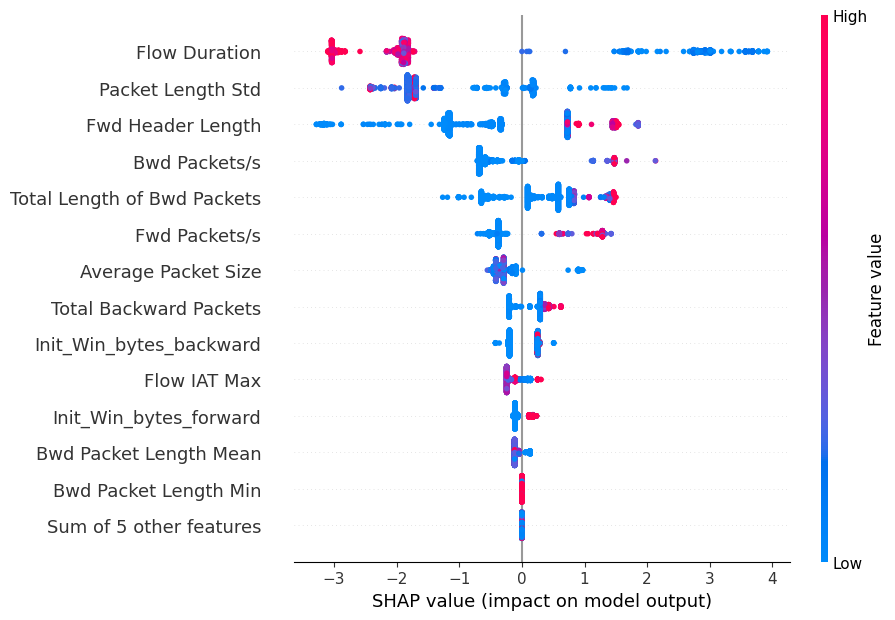

In [ ]:
# shap.plots.bar(shap_values, max_display=1)
# plt.show()

shap.plots.beeswarm(shap_values, max_display=14)
plt.show()

# Anomaly Classification

In [ ]:
pca_10d = PCA(n_components=10)
res_10d = pca_10d.fit_transform(normalized_data)
pca_10d_df = pd.DataFrame(data=res_10d, columns = [f'PC{i+1}' for i in range(res_10d.shape[1])])
print('Explained variation per principal component: {}'.format(pca_10d.explained_variance_ratio_))

Explained variation per principal component: [0.35592025 0.16895813 0.15196824 0.08564042 0.06534654 0.05580156
 0.04777404 0.0435249  0.01787587 0.00462445]


In [ ]:
pca_10d_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,7.087166,-0.082470,0.650177,-1.756847,-2.063885,-0.201096,0.615857,-0.606383,-1.756095,1.896859
1,8.620699,-0.638194,2.064039,0.018481,-1.347184,0.077326,-0.134395,-0.612449,-1.216394,-0.211974
2,8.869074,-0.609572,2.004064,-0.071894,-1.442919,0.066990,-0.094130,-0.643807,-1.271724,-0.218037
3,6.952405,-0.478172,1.471249,0.852608,-1.484193,0.274649,-0.373084,1.985199,-0.994655,-0.145555
4,3.674866,-0.592978,1.573582,1.725777,-1.651162,0.342932,-0.483811,2.311982,-0.095539,-0.073509
...,...,...,...,...,...,...,...,...,...,...
1425,-0.969543,0.390764,-1.137147,0.416766,0.355621,0.087124,-0.522876,-0.609299,-0.337488,0.033910
1426,-0.928155,0.390953,-1.119786,0.366428,0.344673,0.087605,-0.535790,-0.599967,-0.313444,0.033287
1427,-0.253782,-0.456792,1.327017,2.856215,-1.705801,0.525935,-1.418994,-0.286920,0.320514,-0.002357
1428,-1.548936,-0.549004,1.284924,0.620067,-0.515246,-0.947922,3.948902,0.633204,0.396889,-0.078041


In [ ]:
import sklearn.neighbors

lof = sklearn.neighbors.LocalOutlierFactor(contamination=1/50)
outlier_prediction = lof.fit_predict(res_10d)
outlier_scores = lof.negative_outlier_factor_
pca_10d_df['lof_scores'] = outlier_scores
pca_10d_df['Label'] = malicious
pca_10d_df['strLabel'] = labels
# pca_embedding_df['outlier'] = outlier_scores

The palette list has more values (3) than needed (2), which may not be intended.
The palette list has more values (3) than needed (2), which may not be intended.


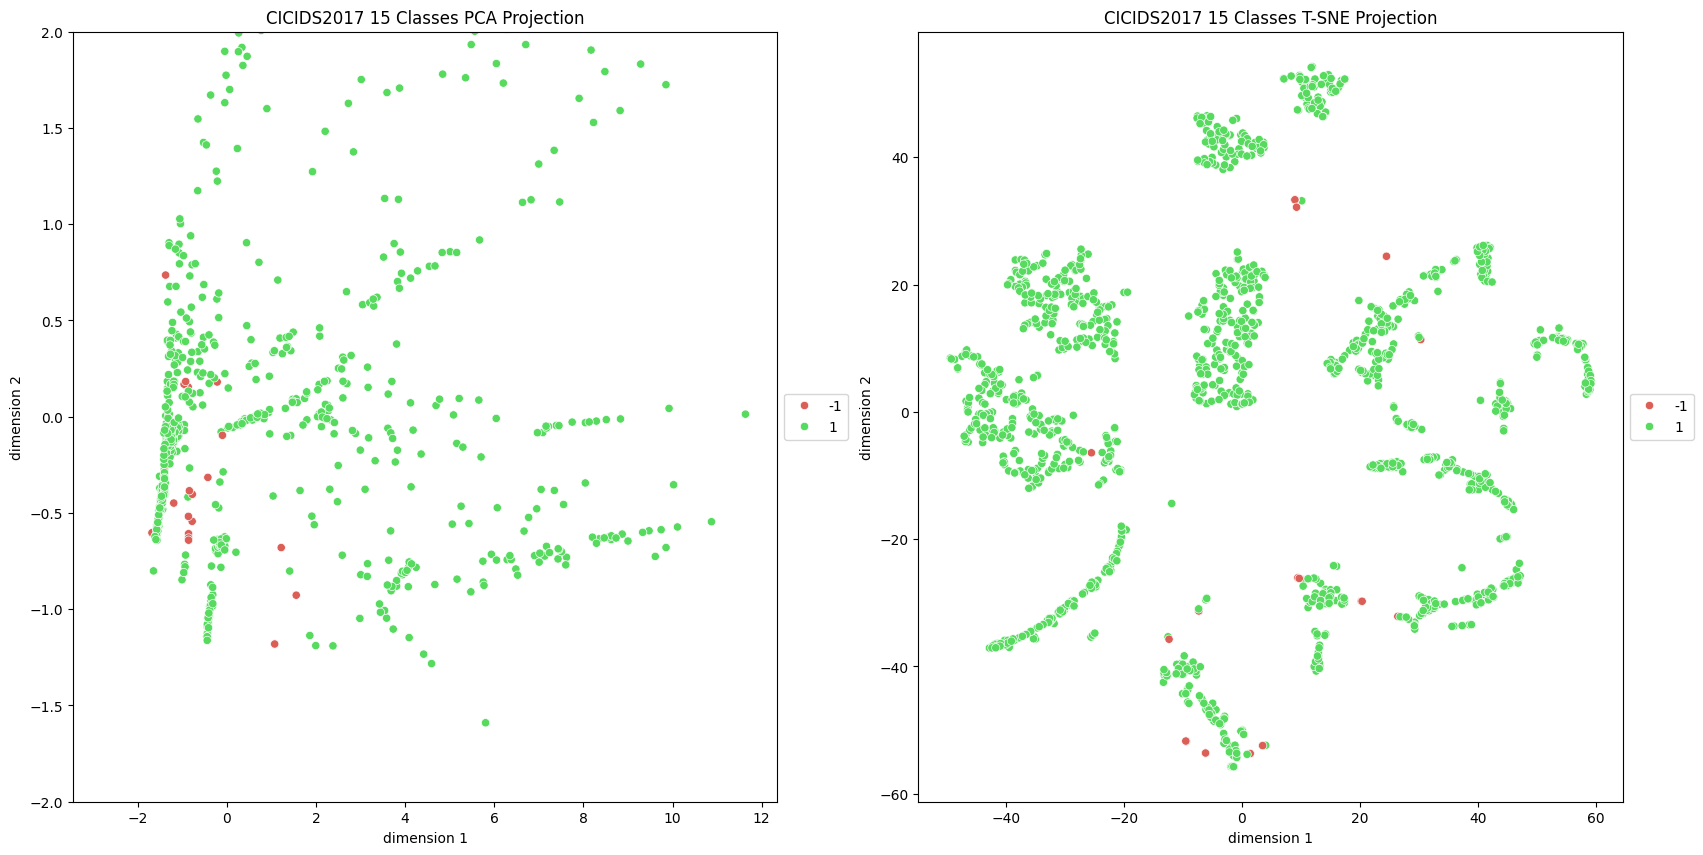

In [ ]:
# tsne_df["Label"] = malicious
# fig, ax = plt.subplot(1,2, figsize=(16,10))
# sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
#                 hue = "Label",
#                 palette = sns.color_palette('hls', len(tsne_df.Label.value_counts())),
#                 data = tsne_df).set(title = 'CICIDS2017 15 Classes T-SNE Projection')
# plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
# plt.show()


fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize to fit your needs

# PCA Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue=outlier_prediction,
                palette=sns.color_palette('hls', len(pca_df['Label'].value_counts())),
                data=pca_df, ax=axes[0])
axes[0].set_title('CICIDS2017 15 Classes PCA Projection')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim(-2, 2)

# t-SNE Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue=outlier_prediction,
                palette=sns.color_palette('hls', len(tsne_df['Label'].value_counts())),
                data=tsne_df, ax=axes[1])
axes[1].set_title('CICIDS2017 15 Classes T-SNE Projection')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))



In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import *

#graph
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import shap

from deepod.models import PReNet
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import pickle


/home/vincent/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def process_csv(filename, label):
  csv_df = pd.read_csv(filename)
  csv_df['Label'] = label
  print(filename)
  return csv_df

In [ ]:
dataset_csv_path = './Dataset/SimulatedCVE' 
csv_file_names = ['dos_ge_dr.csv',
                  'ptbrowsing.csv',
                  'stream.csv'
                  #'dos_stream.csv',
]
df_record = []
for csv_file_name in csv_file_names:
    complete_path = os.path.join(dataset_csv_path, csv_file_name)
    csv_df = process_csv(complete_path, csv_file_name[:-4])
    df_record.append(csv_df)
    
concatenated_df = pd.concat(df_record, ignore_index=True)
concatenated_df    



./Dataset/SimulatedCVE/dos_ge_dr.csv
./Dataset/SimulatedCVE/ptbrowsing.csv
./Dataset/SimulatedCVE/stream.csv


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,Fwd IAT Min,PSH Flag Count,Fwd Packets/s,Bwd Header Length,Label
0,64260,78.840674,502,74608,302.591581,134.687615,5882145,66,521000,42628,26050,137.987825,0,56519,74605,0,9185,0.349158,852560,dos_ge_dr
1,64260,303.408920,64240,19999,303.877612,134.932206,6067875,66,538280,44022,26914,137.837331,0,1638,19998,0,9495,1.345767,880440,dos_ge_dr
2,64260,298.099757,64240,20971,324.400761,138.567478,6251450,66,556900,45409,27845,137.669845,0,1538,20970,0,9905,1.327786,908180,dos_ge_dr
3,64260,241.537172,64240,21118,334.267090,148.840225,5100782,60,419140,33363,20957,152.887390,0,5118,21117,0,8298,0.992376,667260,dos_ge_dr
4,64260,139.985616,64240,20787,512.097618,218.140341,2909881,60,221820,16100,11091,180.737950,0,5118,20782,0,6018,0.533555,322000,dos_ge_dr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,501,1.924983,501,55041,4900.158886,2828.174975,105953,66,33940,1332,1697,79.544294,0,6510,51561,0,1620,0.030832,26640,stream
1540,501,1.964393,501,59510,4807.747306,2762.965660,116901,66,37660,1495,1883,78.194649,0,5009,59508,0,1780,0.031642,29900,stream
1541,64260,0.476142,64240,56983,3554.266542,2013.363636,27132,66,4560,212,228,127.981132,0,7953,56982,0,204,0.004001,4240,stream
1542,501,0.210074,501,51596,529.419710,472.904762,10839,66,360,24,18,451.625000,0,9030,51595,0,16,0.000349,480,stream


In [ ]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
flow_df = clean_df(concatenated_df)

dataset shape (1544, 20)
zero variance columns ['Fwd IAT Min'] dropped
shape after removing zero variance columns: (1544, 19)
0 rows dropped
shape after removing nan: (1544, 19)
shape after dropping duplicates: (1519, 19)
columns which have identical values [] dropped
shape after removing identical value columns: (1519, 19)


In [ ]:
# flow_df = pd.concat([flow_df[flow_df["Label"] != "dos_ge_dr"], flow_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.2).reset_index(drop=True)])

flow_df['Label'].value_counts()

Label
ptbrowsing    825
stream        469
dos_ge_dr     225
Name: count, dtype: int64

In [ ]:
label = flow_df['Label']
normalized_df = flow_df.drop(['Label'], axis = 1)
scaler = StandardScaler()
feature_name = list(normalized_df.columns)
normalized_data = scaler.fit_transform(normalized_df)
normalized_df = pd.DataFrame(normalized_data, columns=feature_name)
normalized_df['Label'] = label.values
normalized_df

,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length,Label
0,2.628943,0.248549,-0.378265,0.008937,-0.682086,-0.723095,3.970038,0.203325,2.936549,3.701218,2.936565,0.081880,-0.040021,0.019659,0.010073,1.140560,0.275795,3.701218,dos_ge_dr
1,2.628943,1.574680,2.748236,-0.063690,-0.681617,-0.722943,4.109234,0.203325,3.051566,3.837908,3.051583,0.079738,-0.040021,-0.053367,-0.062547,1.196607,1.970954,3.837908,dos_ge_dr
2,2.628943,1.543328,2.748236,-0.062397,-0.674144,-0.720676,4.246815,0.203325,3.175502,3.973912,3.175521,0.077353,-0.040021,-0.053500,-0.061255,1.270734,1.940369,3.973912,dos_ge_dr
3,2.628943,1.209312,2.748236,-0.062202,-0.670551,-0.714269,3.384444,-2.436423,2.258562,2.792729,2.258567,0.294010,-0.040021,-0.048736,-0.061059,0.980193,1.369862,2.792729,dos_ge_dr
4,2.628943,0.609625,2.748236,-0.062642,-0.605790,-0.671051,1.742468,-2.436423,0.945187,1.099989,0.945171,0.690528,-0.040021,-0.048736,-0.061505,0.567976,0.589439,1.099989,dos_ge_dr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,-0.380540,-0.205657,-0.378314,-0.017086,0.992201,0.956648,-0.358943,0.203325,-0.305356,-0.348102,-0.305391,-0.750199,-0.040021,-0.046884,-0.020572,-0.227170,-0.265656,-0.348102,stream
1515,-0.380540,-0.205425,-0.378314,-0.011143,0.958548,0.915981,-0.350738,0.203325,-0.280595,-0.332119,-0.280630,-0.769414,-0.040021,-0.048881,-0.010004,-0.198243,-0.264278,-0.332119,stream
1516,2.628943,-0.214213,2.748236,-0.014503,0.502070,0.448506,-0.418015,0.203325,-0.500911,-0.457924,-0.500949,-0.060588,-0.040021,-0.044964,-0.013363,-0.483179,-0.311293,-0.457924,stream
1517,-0.380540,-0.215784,-0.378314,-0.021668,-0.599482,-0.512172,-0.430226,0.203325,-0.528866,-0.476359,-0.528905,4.547233,-0.040021,-0.043531,-0.020527,-0.517169,-0.317505,-0.476359,stream


In [7]:
def get_score(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(confusion_matrix)

# 2D-PCA visualization

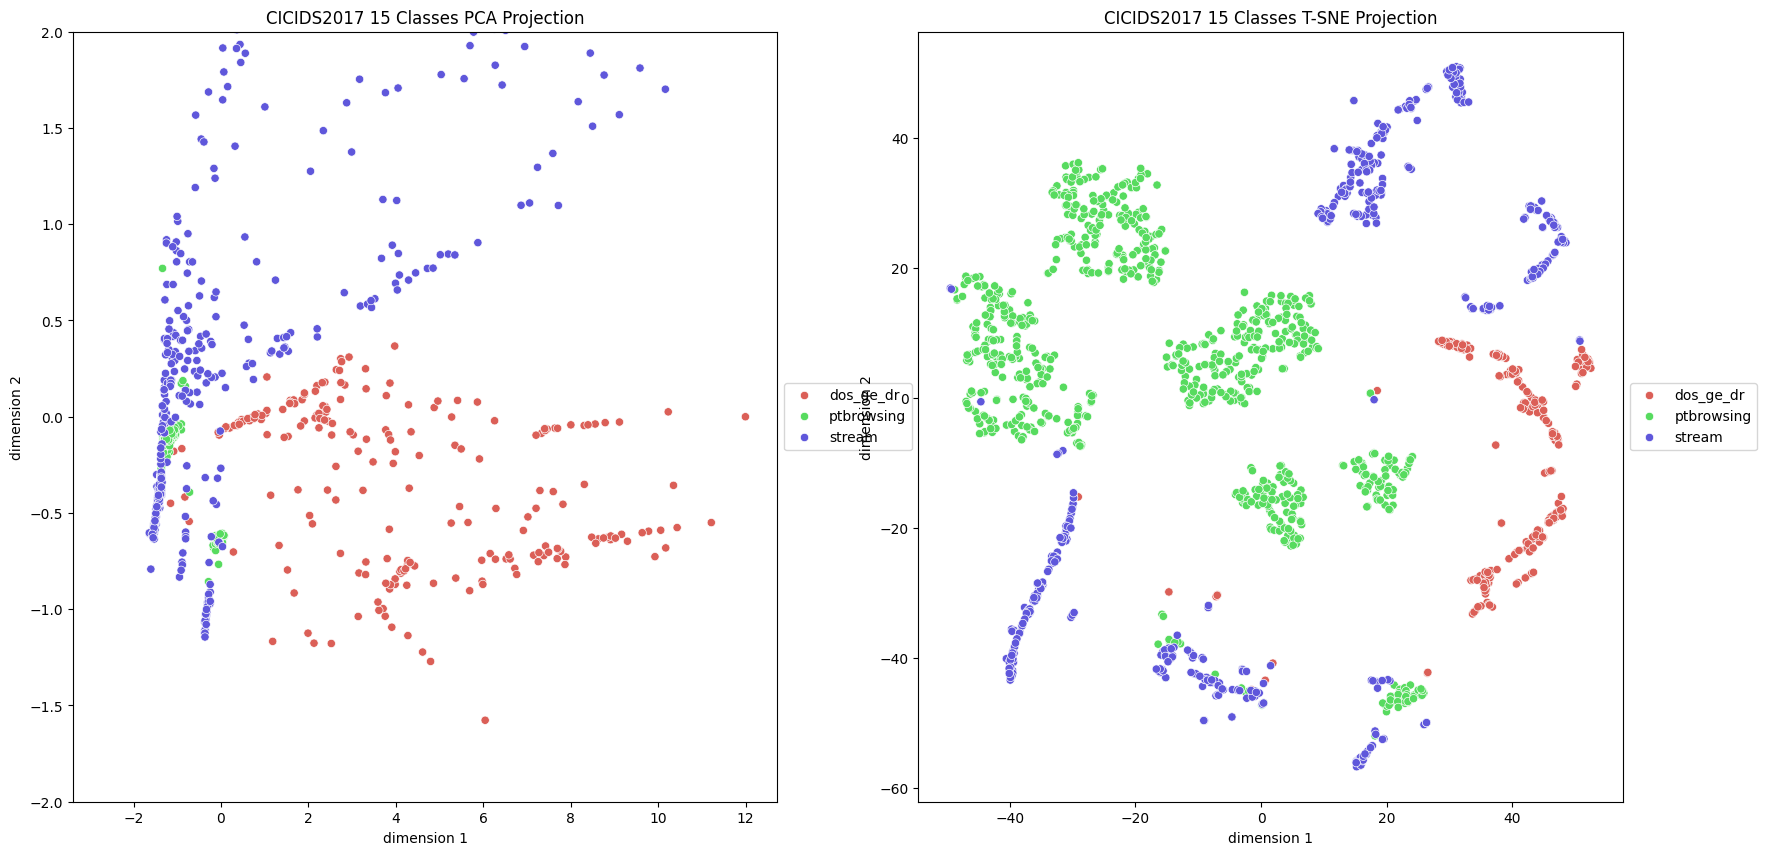

In [8]:
subsample_df = normalized_df
# subsample_df = flow_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)
# subsample_df = pd.concat([subsample_df[subsample_df["Label"] != "dos_ge_dr"], subsample_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.1).reset_index(drop=True)])
X = subsample_df.drop(['Label'], axis=1)
y = subsample_df['Label']

# Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(X)

# Prepare PCA DataFrame for plotting
pca_df = pd.DataFrame(pca_results, columns=['dimension 1', 'dimension 2'])
pca_df['Label'] = y
pca_df['Binary'] = y.apply(lambda x: "malicious" if x == 'dos_ge_dr' else 'benign')


# Apply t-SNE
tsne = TSNE(n_components=2, n_jobs=-1, verbose=0, random_state=0, perplexity=20)
tsne_results = tsne.fit_transform(X)

# Prepare t-SNE DataFrame for plotting
tsne_df = pd.DataFrame(tsne_results, columns=['dimension 1', 'dimension 2'])
tsne_df['Label'] = y

# Create figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize to fit your needs

# PCA Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
                palette=sns.color_palette('hls', len(pca_df['Label'].value_counts())),
                data=pca_df, ax=axes[0])
axes[0].set_title('CICIDS2017 15 Classes PCA Projection')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim(-2, 2)

# t-SNE Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
                palette=sns.color_palette('hls', len(tsne_df['Label'].value_counts())),
                data=tsne_df, ax=axes[1])
axes[1].set_title('CICIDS2017 15 Classes T-SNE Projection')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
pd.DataFrame(res_10d)

NameError: name 'res_10d' is not defined

# XGBoost-ShapValues

Data Processing

In [20]:
le = LabelEncoder()
df = subsample_df.copy()
df['malicious'] = le.fit_transform(df['Label'])
df['malicious'] = df['Label'] == "dos_ge_dr"
malicious = list(df['malicious'].copy())
df


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length,Label,malicious
0,2.628943,0.248549,-0.378265,0.008937,-0.682086,-0.723095,3.970038,0.203325,2.936549,3.701218,2.936565,0.081880,-0.040021,0.019659,0.010073,1.140560,0.275795,3.701218,dos_ge_dr,True
1,2.628943,1.574680,2.748236,-0.063690,-0.681617,-0.722943,4.109234,0.203325,3.051566,3.837908,3.051583,0.079738,-0.040021,-0.053367,-0.062547,1.196607,1.970954,3.837908,dos_ge_dr,True
2,2.628943,1.543328,2.748236,-0.062397,-0.674144,-0.720676,4.246815,0.203325,3.175502,3.973912,3.175521,0.077353,-0.040021,-0.053500,-0.061255,1.270734,1.940369,3.973912,dos_ge_dr,True
3,2.628943,1.209312,2.748236,-0.062202,-0.670551,-0.714269,3.384444,-2.436423,2.258562,2.792729,2.258567,0.294010,-0.040021,-0.048736,-0.061059,0.980193,1.369862,2.792729,dos_ge_dr,True
4,2.628943,0.609625,2.748236,-0.062642,-0.605790,-0.671051,1.742468,-2.436423,0.945187,1.099989,0.945171,0.690528,-0.040021,-0.048736,-0.061505,0.567976,0.589439,1.099989,dos_ge_dr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,-0.380540,-0.205657,-0.378314,-0.017086,0.992201,0.956648,-0.358943,0.203325,-0.305356,-0.348102,-0.305391,-0.750199,-0.040021,-0.046884,-0.020572,-0.227170,-0.265656,-0.348102,stream,False
1515,-0.380540,-0.205425,-0.378314,-0.011143,0.958548,0.915981,-0.350738,0.203325,-0.280595,-0.332119,-0.280630,-0.769414,-0.040021,-0.048881,-0.010004,-0.198243,-0.264278,-0.332119,stream,False
1516,2.628943,-0.214213,2.748236,-0.014503,0.502070,0.448506,-0.418015,0.203325,-0.500911,-0.457924,-0.500949,-0.060588,-0.040021,-0.044964,-0.013363,-0.483179,-0.311293,-0.457924,stream,False
1517,-0.380540,-0.215784,-0.378314,-0.021668,-0.599482,-0.512172,-0.430226,0.203325,-0.528866,-0.476359,-0.528905,4.547233,-0.040021,-0.043531,-0.020527,-0.517169,-0.317505,-0.476359,stream,False


In [21]:
malicious = list(df['malicious'].copy())
print(malicious)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [22]:
labels = df['Label'].copy()
malicious = list(df['malicious'].copy())
df.drop(columns='Label', axis=1, inplace=True)
df.drop(columns='malicious', axis=1, inplace=True)

df = df[:]

df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df = df.fillna(df.mean())

df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])
# df = df.loc[:, (df != df.iloc[0]).any()] #Remove features that are constant
indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df = df[indices_to_keep]


for i in df.columns:
    df = df[df[i] != "Infinity"]
    df = df[df[i] != np.nan]
    df = df[df[i] != np.inf]
    df = df[df[i] != -np.inf]
    df = df[df[i] != ",,"]
    df = df[df[i] != ", ,"]
    
print(np.any(np.isnan(df)))
print(np.any(np.isfinite(df)))


# Last column turn to binary
# df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 1 if x != 0 else 0).astype(int)
#Standardize Dataframe
scaler = StandardScaler()
feature_name = list(df.columns)
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=feature_name)
df['malicious'] = malicious


X_train, X_test, y_train, y_test = train_test_split(df.drop(['malicious'],axis=1), df['malicious'], test_size=.20, random_state=42)
print(X_train.shape, y_train.shape)
X_train

False
True
(1215, 18) (1215,)


,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length
1316,-0.380446,-0.216949,-0.378265,-0.083478,-0.791187,-0.767802,-0.438300,0.203325,-0.531023,-0.478614,-0.530902,-0.943033,-0.040021,-0.055546,-0.089142,-0.520062,-0.317102,-0.478614
1301,-0.380540,-0.215568,-0.400633,-0.066410,-0.244335,-0.003629,-0.435030,0.203325,-0.524340,-0.474006,-0.524379,-0.569007,-0.040021,-0.051030,-0.069260,-0.512468,-0.313172,-0.474006
843,-0.380540,-0.203894,-0.375862,-0.014368,-0.102077,-0.103310,-0.343221,0.203325,-0.390154,-0.379087,-0.390191,-0.103998,-0.040021,-0.030183,-0.023416,-0.329321,-0.286514,-0.379087
1283,-0.380540,-0.217006,-0.378314,-0.034113,-0.791187,-0.767802,-0.438251,0.203325,-0.530783,-0.478516,-0.530503,-0.943033,-0.040021,-0.015957,-0.042842,-0.520062,-0.317857,-0.478516
1048,-0.380540,-0.209959,-0.378314,-0.050458,-0.117662,-0.088305,-0.411494,0.203325,-0.490794,-0.450962,-0.490832,-0.079990,-0.040021,-0.018407,-0.049316,-0.465099,-0.300832,-0.450962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2.628943,-0.216421,2.748236,-0.070495,-0.607654,-0.566013,-0.437210,0.203325,-0.530863,-0.478320,-0.530902,3.531044,-0.040021,-0.035765,-0.069352,-0.519700,-0.317756,-0.478320
1294,-0.380540,-0.216905,-0.378265,-0.024713,-0.709593,-0.726512,-0.437598,0.203325,-0.529825,-0.478124,-0.528905,0.497309,-0.040021,-0.036623,-0.023588,-0.519700,-0.317477,-0.478124
860,-0.380540,-0.199991,-0.378314,-0.039146,-0.113692,-0.112104,-0.355219,0.203325,-0.407726,-0.390560,-0.407763,-0.126042,-0.040021,-0.035377,-0.038004,-0.351920,-0.277050,-0.390560
1459,-0.363029,-0.191478,0.081601,-0.011671,0.306086,0.572412,-0.246693,0.203325,-0.013154,-0.140517,-0.013185,-0.827058,-0.040021,-0.051709,-0.010534,0.145091,-0.206109,-0.140517


In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic')
_= model.fit(X_train,y_train)
model_outputs = model.predict(X_train)
pred = model.score(X_test, y_test)
print(pred)

1.0


SHAP

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
np.shape(shap_values.values)

[11:38:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


(1144, 18)

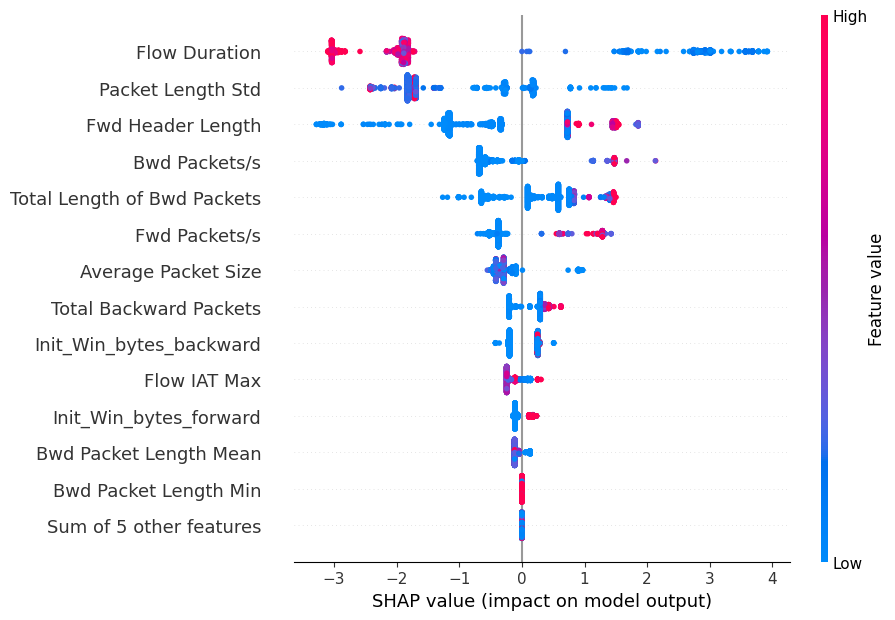

In [ ]:
# shap.plots.bar(shap_values, max_display=1)
# plt.show()

shap.plots.beeswarm(shap_values, max_display=14)
plt.show()

# Anomaly Classification

In [ ]:
pca_10d = PCA(n_components=10)
res_10d = pca_10d.fit_transform(normalized_data)
pca_10d_df = pd.DataFrame(data=res_10d, columns = [f'PC{i+1}' for i in range(res_10d.shape[1])])
print('Explained variation per principal component: {}'.format(pca_10d.explained_variance_ratio_))

Explained variation per principal component: [0.35592025 0.16895813 0.15196824 0.08564042 0.06534654 0.05580156
 0.04777404 0.0435249  0.01787587 0.00462445]


In [ ]:
pca_10d_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,7.087166,-0.082470,0.650177,-1.756847,-2.063885,-0.201096,0.615857,-0.606383,-1.756095,1.896859
1,8.620699,-0.638194,2.064039,0.018481,-1.347184,0.077326,-0.134395,-0.612449,-1.216394,-0.211974
2,8.869074,-0.609572,2.004064,-0.071894,-1.442919,0.066990,-0.094130,-0.643807,-1.271724,-0.218037
3,6.952405,-0.478172,1.471249,0.852608,-1.484193,0.274649,-0.373084,1.985199,-0.994655,-0.145555
4,3.674866,-0.592978,1.573582,1.725777,-1.651162,0.342932,-0.483811,2.311982,-0.095539,-0.073509
...,...,...,...,...,...,...,...,...,...,...
1425,-0.969543,0.390764,-1.137147,0.416766,0.355621,0.087124,-0.522876,-0.609299,-0.337488,0.033910
1426,-0.928155,0.390953,-1.119786,0.366428,0.344673,0.087605,-0.535790,-0.599967,-0.313444,0.033287
1427,-0.253782,-0.456792,1.327017,2.856215,-1.705801,0.525935,-1.418994,-0.286920,0.320514,-0.002357
1428,-1.548936,-0.549004,1.284924,0.620067,-0.515246,-0.947922,3.948902,0.633204,0.396889,-0.078041


In [ ]:
import sklearn.neighbors

lof = sklearn.neighbors.LocalOutlierFactor(contamination=1/50)
outlier_prediction = lof.fit_predict(res_10d)
outlier_scores = lof.negative_outlier_factor_
pca_10d_df['lof_scores'] = outlier_scores
pca_10d_df['Label'] = malicious
pca_10d_df['strLabel'] = labels
# pca_embedding_df['outlier'] = outlier_scores

The palette list has more values (3) than needed (2), which may not be intended.
The palette list has more values (3) than needed (2), which may not be intended.


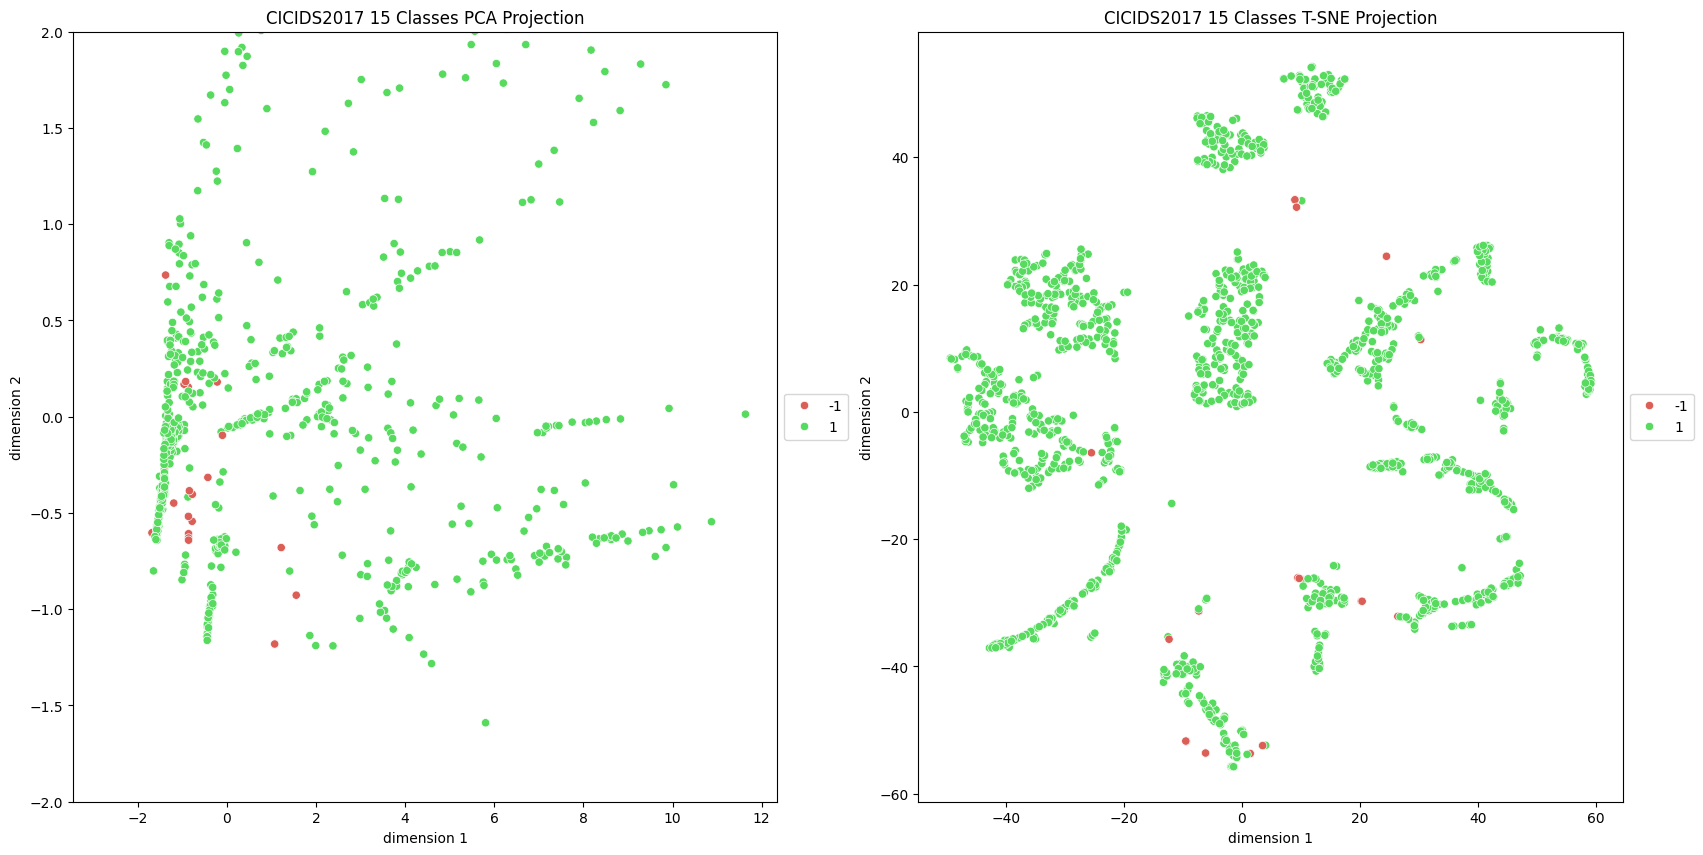

In [ ]:
# tsne_df["Label"] = malicious
# fig, ax = plt.subplot(1,2, figsize=(16,10))
# sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
#                 hue = "Label",
#                 palette = sns.color_palette('hls', len(tsne_df.Label.value_counts())),
#                 data = tsne_df).set(title = 'CICIDS2017 15 Classes T-SNE Projection')
# plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
# plt.show()


fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize to fit your needs

# PCA Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue=outlier_prediction,
                palette=sns.color_palette('hls', len(pca_df['Label'].value_counts())),
                data=pca_df, ax=axes[0])
axes[0].set_title('CICIDS2017 15 Classes PCA Projection')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim(-2, 2)

# t-SNE Plot
sns.scatterplot(x='dimension 1', y='dimension 2', hue=outlier_prediction,
                palette=sns.color_palette('hls', len(tsne_df['Label'].value_counts())),
                data=tsne_df, ax=axes[1])
axes[1].set_title('CICIDS2017 15 Classes T-SNE Projection')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))



The palette list has more values (6) than needed (3), which may not be intended.


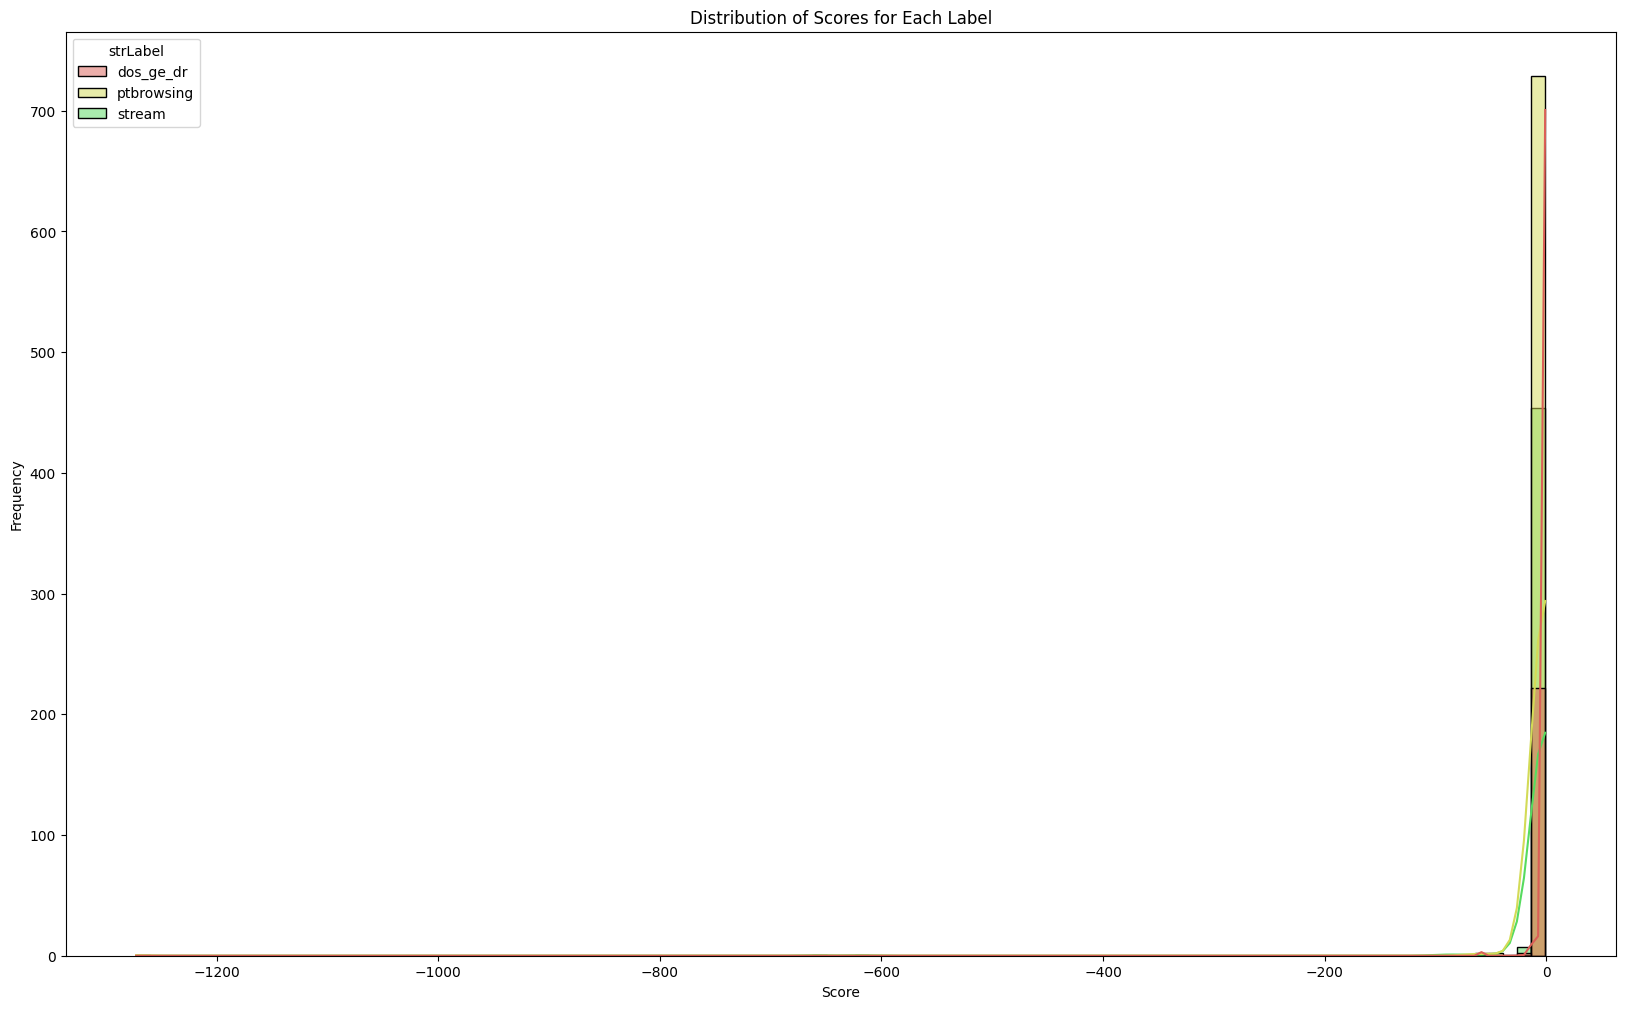

In [ ]:
plt.figure(figsize=(20, 12))
# att_df = pca_10d_df.loc[pca_10d_df['Label'] == 1]
sns.histplot(data=pca_10d_df, x='lof_scores', hue='strLabel', palette=sns.color_palette("hls",6), kde=True, bins=100)  # KDE adds a density plot
plt.title('Distribution of Scores for Each Label')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Clustering Classification

### Dimensionality Reduction

In [22]:
pca = PCA(n_components=5, random_state=42)
pca_results = pca.fit_transform(normalized_data)
pca_5d_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(pca_results.shape[1])])
pca_5d_df['Label'] = normalized_df['Label'].values
pca_5d_df

,PC1,PC2,PC3,PC4,PC5,Label
0,7.087166,-0.082470,0.650177,-1.756847,-2.063885,dos_ge_dr
1,8.620699,-0.638194,2.064039,0.018481,-1.347184,dos_ge_dr
2,8.869074,-0.609572,2.004064,-0.071894,-1.442919,dos_ge_dr
3,6.952405,-0.478172,1.471249,0.852608,-1.484193,dos_ge_dr
4,3.674866,-0.592978,1.573582,1.725777,-1.651162,dos_ge_dr
...,...,...,...,...,...,...
1425,-0.969543,0.390764,-1.137147,0.416766,0.355621,stream
1426,-0.928155,0.390953,-1.119786,0.366428,0.344673,stream
1427,-0.253782,-0.456792,1.327017,2.856215,-1.705801,stream
1428,-1.548936,-0.549004,1.284924,0.620067,-0.515246,stream


### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
# Assuming X is your feature matrix

X_scaled = StandardScaler().fit_transform(pca_results)

# DBSCAN clustering
dbscan = DBSCAN(eps =0.35, min_samples=80)
dbscan.fit(X_scaled)
cluster_labels = dbscan.labels_

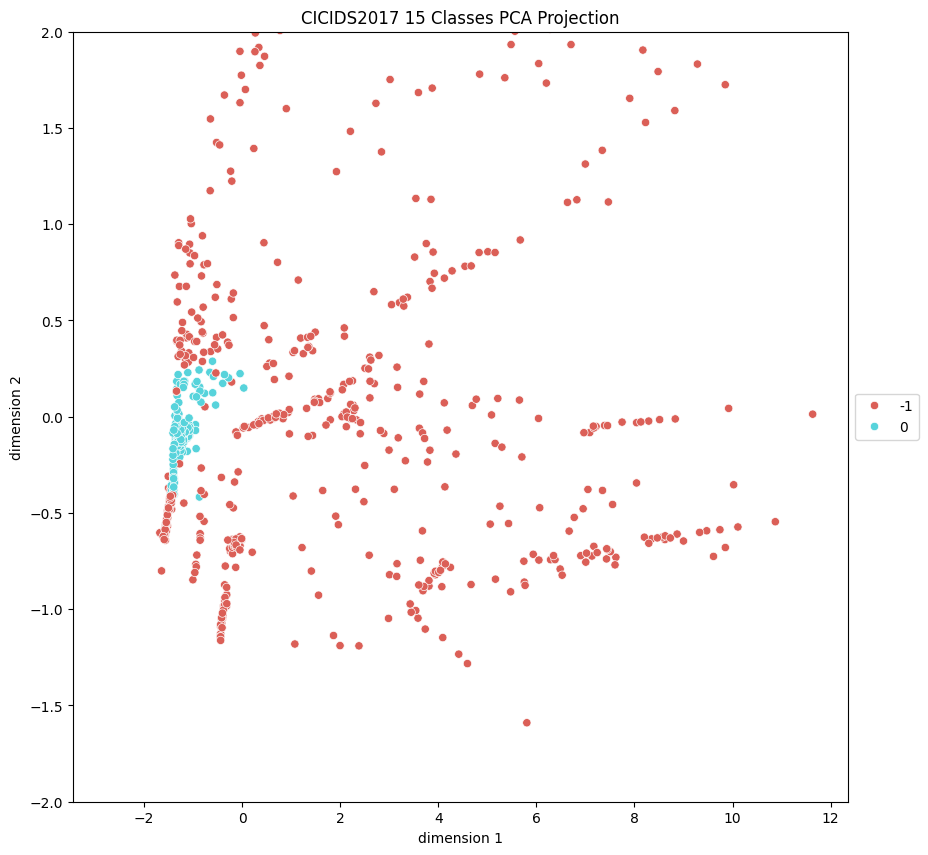

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(x='dimension 1', y='dimension 2', hue=cluster_labels,
                palette=sns.color_palette('hls', len(set(dbscan.labels_))),
                data=pca_df, ax=axes)
axes.set_title('CICIDS2017 15 Classes PCA Projection')
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes.set_ylim(-2, 2)
plt.show()

## KNN

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

def knn_train(data):
  pca_results = data.drop("Label", axis=1, inplace=False)
  X_scaled = StandardScaler().fit_transform(pca_results)
  data['Binary'] = data['Label'].apply(lambda x: 'malicious' if x == 'dos_ge_dr' else 'benign')
  y = data['Binary']

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize the KNN model. Let's start with K=5
  knn = KNeighborsClassifier(n_neighbors=5)

  # Train the model
  knn.fit(X_train, y_train)
  return knn, X_test,y_test


### KNN 3 Class Classification

In [17]:

# Splitting the data into features and target
X = X_scaled
y = pca_5d_df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN model. Let's start with K=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Predict labels for the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

NameError: name 'X_scaled' is not defined

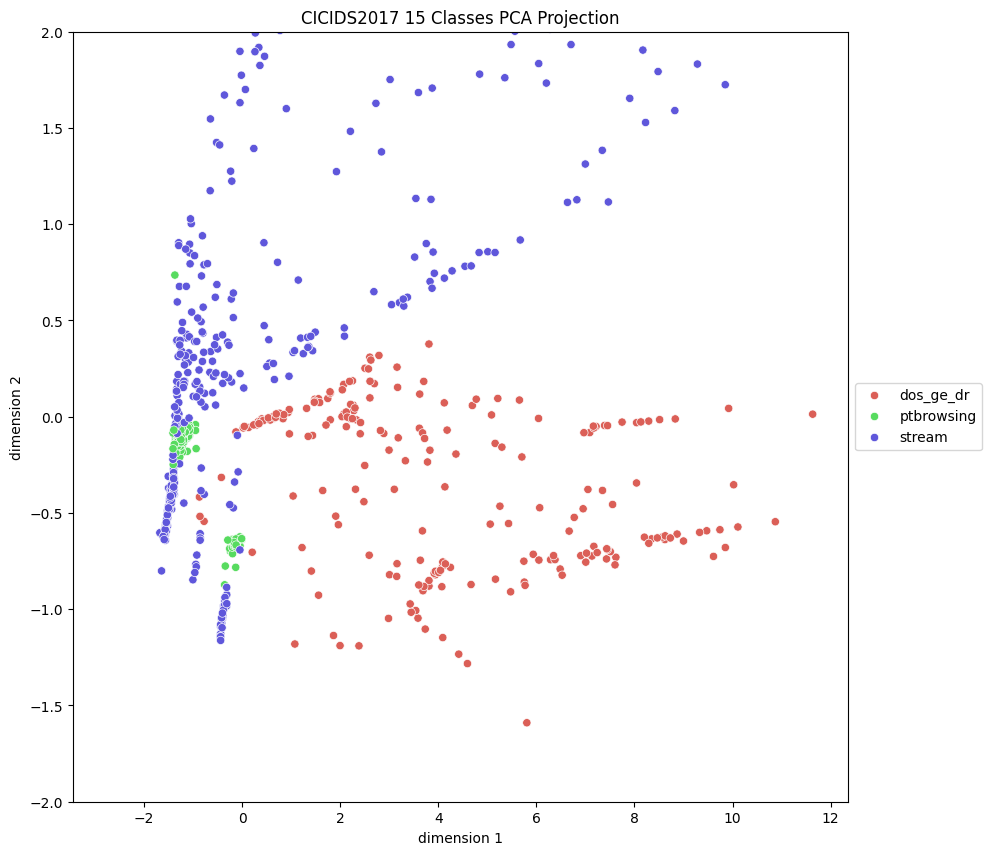

In [ ]:
knn_labels = knn.predict(X_scaled)
fig, axes = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(x='dimension 1', y='dimension 2', hue=knn_labels,
                palette=sns.color_palette('hls', len(set(knn_labels))),
                data=pca_df, ax=axes)
axes.set_title('CICIDS2017 15 Classes PCA Projection')
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes.set_ylim(-2, 2)
plt.show()

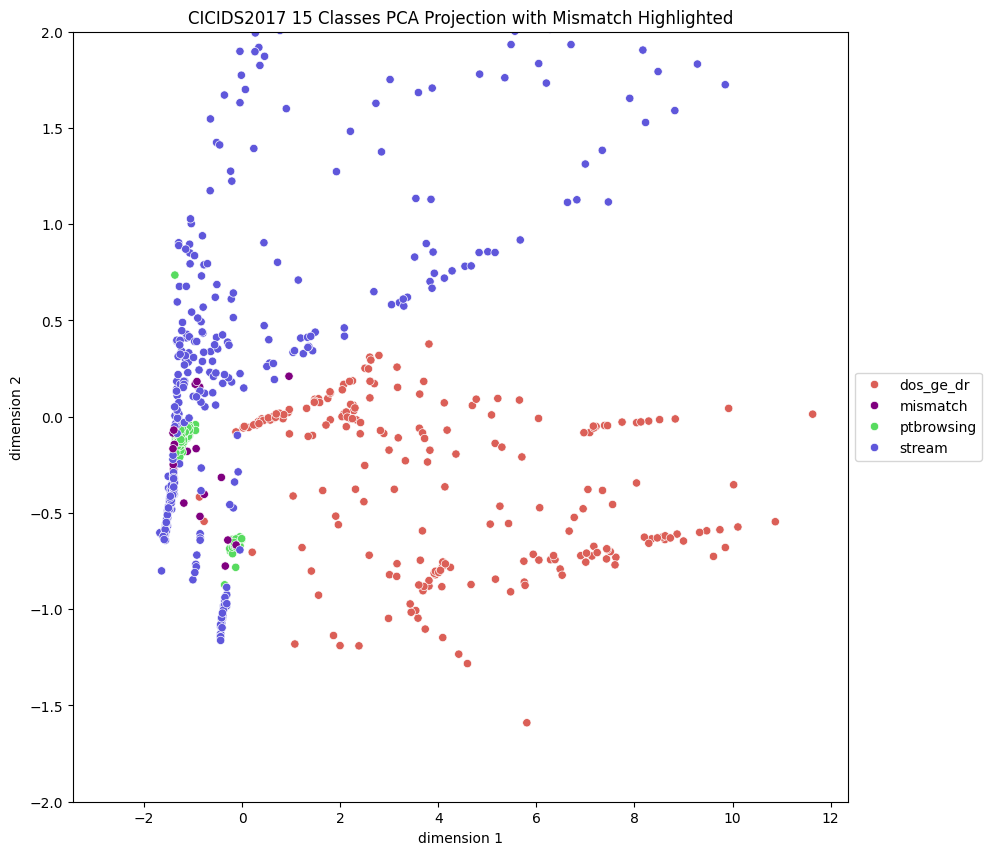

In [ ]:
# Assuming `y` is your ground truth labels and is of the same order as `pca_df`
pca_df['knn_labels'] = knn_labels
pca_df['Label_Match'] = pca_df['Label'] == pca_df['knn_labels']

# Create a new column for coloring
# If Label_Match is True, use the knn label, else use 'mismatch' to indicate a prediction error
pca_df['Color'] = pca_df.apply(lambda row: row['knn_labels'] if row['Label_Match'] else 'mismatch', axis=1)
fig, axes = plt.subplots(figsize=(10, 10))

# Define a custom palette where 'mismatch' is colored purple, and other categories as before
unique_labels = pca_df['knn_labels'].unique()
palette = sns.color_palette('hls', len(unique_labels)) + ["purple"]  # Adding purple for mismatches

# Map each unique label to a color, with 'mismatch' mapped to purple
color_mapping = {label: palette[i] for i, label in enumerate(unique_labels)}
color_mapping['mismatch'] = "purple"

sns.scatterplot(x='dimension 1', y='dimension 2', hue='Color',
                palette=color_mapping,
                data=pca_df, ax=axes, legend='full')

axes.set_title('CICIDS2017 15 Classes PCA Projection with Mismatch Highlighted')
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes.set_ylim(-2, 2)
plt.show()


### KNN Binary Classication

In [66]:
knn, X_test, y_test = knn_train(pca_5d_df.copy())

# Predict labels for the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
knn_labels = knn.predict(X.copy())

Accuracy: 0.986013986013986

Classification Report:
               precision    recall  f1-score   support

      benign       0.99      0.99      0.99       246
   malicious       0.95      0.95      0.95        40

    accuracy                           0.99       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.99      0.99      0.99       286



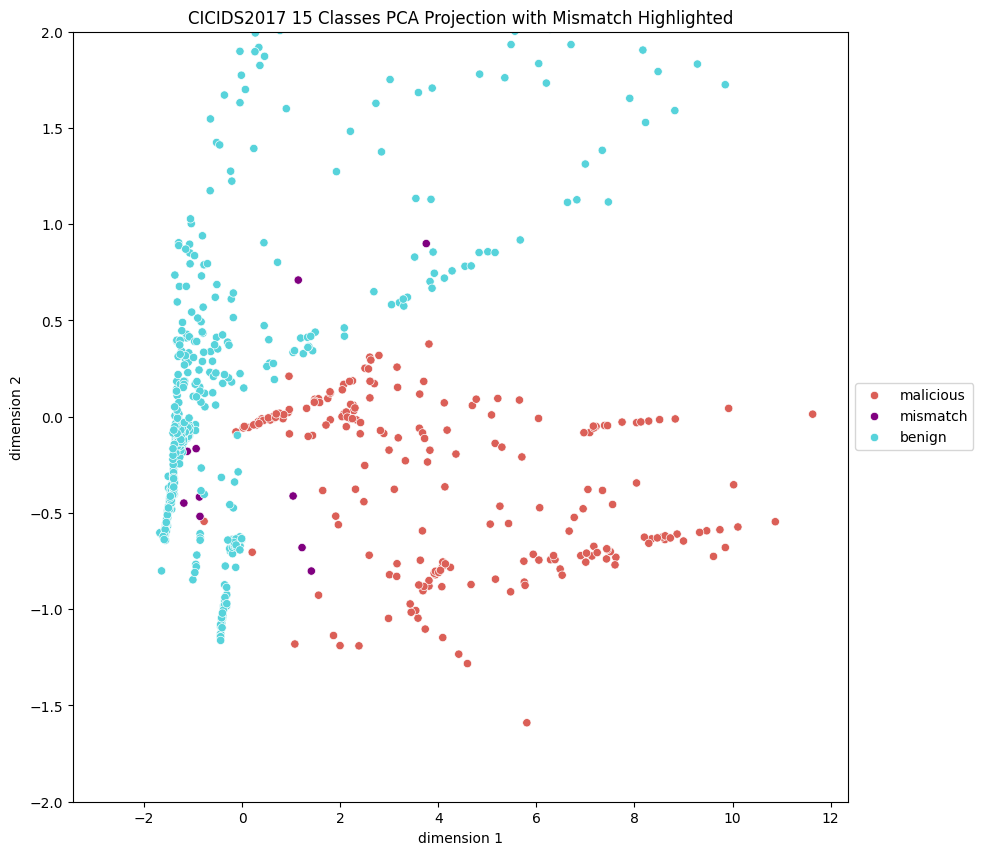

In [67]:
# Assuming `y` is your ground truth labels and is of the same order as `pca_df`
pca_df['knn_labels'] = knn_labels
pca_df['Label_Match'] = pca_df['Binary'] == pca_df['knn_labels']

# Create a new column for coloring
# If Label_Match is True, use the knn label, else use 'mismatch' to indicate a prediction error
pca_df['Color'] = pca_df.apply(lambda row: row['Binary'] if row['Label_Match'] else 'mismatch', axis=1)
fig, axes = plt.subplots(figsize=(10, 10))

# Define a custom palette where 'mismatch' is colored purple, and other categories as before
unique_labels = pca_df['Binary'].unique()
palette = sns.color_palette('hls', len(unique_labels)) + ["purple"]  # Adding purple for mismatches

# Map each unique label to a color, with 'mismatch' mapped to purple
color_mapping = {label: palette[i] for i, label in enumerate(unique_labels)}
color_mapping['mismatch'] = "purple"

sns.scatterplot(x='dimension 1', y='dimension 2', hue='Color',
                palette=color_mapping,
                data=pca_df, ax=axes, legend='full')

axes.set_title('CICIDS2017 15 Classes PCA Projection with Mismatch Highlighted')
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes.set_ylim(-2, 2)
plt.show()


### KNN Active Learning

In [124]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def get_sus(knn_model, X_new, y_test, y_pred): #Record the Suspicious Data and compare it with the mismatch labels
    # Predict the class for a new data point
    X_new = X_new.copy()
    X_new.reset_index(drop=True, inplace=True)
    predicted_class = knn_model.predict(X_new)
    
    # Get the k nearest neighbors
    distances, indices = knn_model.kneighbors(X_new)
    
    
    # Access the labels of the nearest neighbors
    neighbor_labels = knn_model.classes_[knn_model._y[indices].astype(int)]
    
    # Count the votes for each class
    sus_df = pd.DataFrame()
    for X_new_idx,neighbor in enumerate(neighbor_labels):
        votes = {label: 0 for label in knn_model.classes_}
        votes['benign'] = np.count_nonzero(neighbor == "benign")
        votes['malicious'] = np.count_nonzero(neighbor == "malicious")
        if votes["benign"] != 5 and votes['malicious'] != 5:
            print(X_new_idx, votes)
            sus_df = pd.concat([sus_df, X_new.iloc[[X_new_idx]]])
    
    mismatch_indices = np.where(y_test.values != y_pred)[0]
    print("Actual Mismatch Prediction = ", list(mismatch_indices))
    print("Suspicious index", sus_df.index)
    
    return sus_df

# Example usage:
sus_df = get_sus(knn,X_test, y_test, y_pred)
sus_df

101 {'benign': 4, 'malicious': 1}
123 {'benign': 4, 'malicious': 1}
153 {'benign': 3, 'malicious': 2}
182 {'benign': 3, 'malicious': 2}
218 {'benign': 3, 'malicious': 2}
247 {'benign': 2, 'malicious': 3}
273 {'benign': 4, 'malicious': 1}
285 {'benign': 1, 'malicious': 4}


ValueError: operands could not be broadcast together with shapes (286,) (1430,) 

In [129]:
pca_5d_df['Binary'] = pca_5d_df['Label'].apply(lambda x: 'malicious' if x == 'dos_ge_dr' else 'benign')
y = pca_5d_df['Binary']
y_pred = knn.predict(X)
sus_df = get_sus(knn, X, y, y_pred)

119 {'benign': 4, 'malicious': 1}
122 {'benign': 4, 'malicious': 1}
127 {'benign': 3, 'malicious': 2}
134 {'benign': 3, 'malicious': 2}
142 {'benign': 3, 'malicious': 2}
153 {'benign': 3, 'malicious': 2}
176 {'benign': 4, 'malicious': 1}
203 {'benign': 3, 'malicious': 2}
210 {'benign': 2, 'malicious': 3}
211 {'benign': 3, 'malicious': 2}
212 {'benign': 2, 'malicious': 3}
217 {'benign': 1, 'malicious': 4}
220 {'benign': 4, 'malicious': 1}
243 {'benign': 3, 'malicious': 2}
275 {'benign': 3, 'malicious': 2}
293 {'benign': 4, 'malicious': 1}
711 {'benign': 4, 'malicious': 1}
712 {'benign': 4, 'malicious': 1}
749 {'benign': 4, 'malicious': 1}
750 {'benign': 4, 'malicious': 1}
1200 {'benign': 3, 'malicious': 2}
1222 {'benign': 2, 'malicious': 3}
1249 {'benign': 4, 'malicious': 1}
1293 {'benign': 4, 'malicious': 1}
1304 {'benign': 4, 'malicious': 1}
1305 {'benign': 2, 'malicious': 3}
1363 {'benign': 4, 'malicious': 1}
1364 {'benign': 1, 'malicious': 4}
Actual Mismatch Prediction =  [119, 122,

In [126]:
y_pred

array(['malicious', 'malicious', 'malicious', ..., 'benign', 'benign',
       'benign'], dtype=object)

In [127]:
y.values

array(['dos_ge_dr', 'dos_ge_dr', 'dos_ge_dr', ..., 'stream', 'stream',
       'stream'], dtype=object)

In [128]:
pca_5d_df

,PC1,PC2,PC3,PC4,PC5,Label
0,7.087166,-0.082470,0.650177,-1.756847,-2.063885,dos_ge_dr
1,8.620699,-0.638194,2.064039,0.018481,-1.347184,dos_ge_dr
2,8.869074,-0.609572,2.004064,-0.071894,-1.442919,dos_ge_dr
3,6.952405,-0.478172,1.471249,0.852608,-1.484193,dos_ge_dr
4,3.674866,-0.592978,1.573582,1.725777,-1.651162,dos_ge_dr
...,...,...,...,...,...,...
1425,-0.969543,0.390764,-1.137147,0.416766,0.355621,stream
1426,-0.928155,0.390953,-1.119786,0.366428,0.344673,stream
1427,-0.253782,-0.456792,1.327017,2.856215,-1.705801,stream
1428,-1.548936,-0.549004,1.284924,0.620067,-0.515246,stream


# CART

In [37]:
df = normalized_df.copy()

In [41]:
improved_df = df.copy()
anomaly_rate = 1.0
# Sample the Anomaly Rate
#### Sample out Malicious data such that it would become an outlier
print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
improved_df = pd.concat([improved_df[improved_df['Label'] != 'dos_ge_dr'], improved_df[improved_df['Label'] == 'dos_ge_dr'].sample(frac=anomaly_rate, random_state=42)]) 
print(f'improved_df.shape {improved_df.shape} after Sampling Out')
ratio = improved_df.loc[improved_df["Label"] != "dos_ge_dr"].shape[0]/ improved_df.loc[improved_df["Label"] == "dos_ge_dr"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')
# Dataset
scaler = StandardScaler()
Y = improved_df['Label'].map({"dos_ge_dr":1}).fillna(0)
X = improved_df.copy().drop(columns=["Label"], axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

train_perc = 0.8

# benign training and testing

X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    Y, 
                                                    test_size = 1-train_perc, 
                                                    shuffle = True, 
                                                    stratify = Y, 
                                                    random_state = 0)

improved_df.shape (1519, 19) Before Sampling Out
improved_df.shape (1519, 19) after Sampling Out
Ratio of Benign to Anomaly is 5.751111111111111 : 1


In [42]:
CART = DecisionTreeClassifier()
CART.fit(X=X_train, y=y_train)

DecisionTreeClassifier()

In [43]:
cart_pred = CART.predict(X_test)
get_score(cart_pred, y_test)
with open('decision_tree_classifier.pkl', 'wb') as file:
    pickle.dump(CART, file)

Accuracy: 0.9967
Precision: 0.9778
Recall: 1.0000
F1 Score: 0.9888
[[259   1]
 [  0  44]]


In [44]:
with open('decision_tree_classifier.pkl', 'rb') as file:
  loaded_cart = pickle.load(file)
  
pred = loaded_cart.predict(X_test)
get_score(pred, y_test)

Accuracy: 0.9967
Precision: 0.9778
Recall: 1.0000
F1 Score: 0.9888
[[259   1]
 [  0  44]]


# PReNet

In [9]:


def plot_graph(anomaly_scores, y_test):
    # Separate anomaly scores based on the labels
    scores_inliers = anomaly_scores[y_test == 0]  # Assuming '0' is the label for inliers
    scores_outliers = anomaly_scores[y_test == 1]  # Assuming '1' is the label for outliers

    # Create the plots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted for better visualization

    # Plot for inliers and outliers
    ax[0].hist(scores_inliers, bins=100, alpha=0.7, label='Inliers', log=True)
    ax[0].hist(scores_outliers, bins=100, alpha=0.7, label='Outliers', log=True)
    ax[0].set_title('Distribution of Anomaly Scores')
    ax[0].set_xlabel('Anomaly Score')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.95, 1.01])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, anomaly_scores)
    pr_auc = auc(recall, precision)
    ax[2].plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.5f)' % pr_auc)
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_title('Precision-Recall Curve')
    ax[2].legend(loc="lower left")

    # Show the plot
    plt.show()

# Example usage
# anomaly_scores = np.array([...])  # Your anomaly scores array
# y_test = np.array([...])  # Your ground truth labels array
# plot_graph(anomaly_scores, y_test)

def plot_comparison_graph(metrics_dict, supervision_rate_list):
  fig, ax = plt.subplots(4, 1, figsize=(10, 16))  # Create a figure and a set of subplots.

  # Plot ROC curves on the first subplot
  for rate, fpr in metrics_dict['fpr'].items():
      tpr = metrics_dict['tpr'][rate]
      roc_auc = auc(fpr,tpr)
      ax[0].plot(fpr, tpr, label=f'Supervision {rate*100:.0f}%, area {roc_auc:.5f}')
  ax[0].set_title('ROC Curve Comparison')
  ax[0].set_xlabel('False Positive Rate')
  ax[0].set_ylabel('True Positive Rate')
  ax[0].legend()
  ax[0].grid(True)
  
  for rate, fpr in metrics_dict['fpr'].items():
      tpr = metrics_dict['tpr'][rate]
      roc_auc = auc(fpr,tpr)
      ax[1].plot(fpr, tpr, label=f'Supervision {rate*100:.0f}%, area {roc_auc:.5f}')
  ax[1].set_title('ROC Curve Comparison')
  ax[1].set_xlabel('False Positive Rate')
  ax[1].set_ylabel('True Positive Rate')
  ax[1].set_ylim([0.9,1.02])
  ax[1].legend()
  ax[1].grid(True)  

  # Plot Precision-Recall curves on the second subplot
  for rate, precision in metrics_dict['precision'].items():
      recall = metrics_dict['recall'][rate]
      pr_auc = auc(recall,precision)
      ax[2].plot(recall, precision, label=f'Supervision {rate*100:.0f}%, area {pr_auc:.5f}')
  ax[2].set_title('Precision-Recall Curve Comparison')
  ax[2].set_xlabel('Recall')
  ax[2].set_ylabel('Precision')
  ax[2].legend()
  ax[2].grid(True)
  
  rate_list = [rate for rate in supervision_rate_list]
  accuracy_list = [metrics_dict['accuracy'][rate] for rate in rate_list]  # Corrected access to accuracy
  labels = [f"{rate*100:.0f}, {metrics_dict['accuracy'][rate]:.5f}" for rate in rate_list]  # Convert rates to percentage labels

  # Set the width of the bars to make them narrower
  bar_width = 0.4  # Smaller value results in narrower bars
  bars = ax[3].bar(labels, accuracy_list, color='skyblue', width=bar_width)

  # Adding labels to each bar
  for bar in bars:
      yval = bar.get_height()
      ax[3].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')  
  ax[3].set_xlabel('Supervision Rate (%)')
  ax[3].set_ylabel('Accuracy')
  ax[3].set_title('Model Accuracy at Different Supervision Rates')
  ax[3].set_ylim([0, 1.05])  # Assuming accuracy values are normalized [0,1]
  ax[3].grid(True, which='both', linestyle='--', linewidth=0.5)
  
  plt.tight_layout()
  plt.show()    
  
  
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


## Model Training

In [10]:
df = normalized_df.copy()

improved_df.shape (1519, 19) Before Sampling Out
improved_df.shape (1519, 19) after Sampling Out
Ratio of Benign to Anomaly is 5.751111111111111 : 1
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 1.0
Start Training...
ensemble size: 1
epoch  1, training loss: 2.607979, time: 0.0s
epoch 10, training loss: 0.250912, time: 0.0s
Start Inference on the training data...
Accuracy: 0.9934
Precision: 0.9556
Recall: 1.0000
F1 Score: 0.9773
[[259   2]
 [  0  43]]


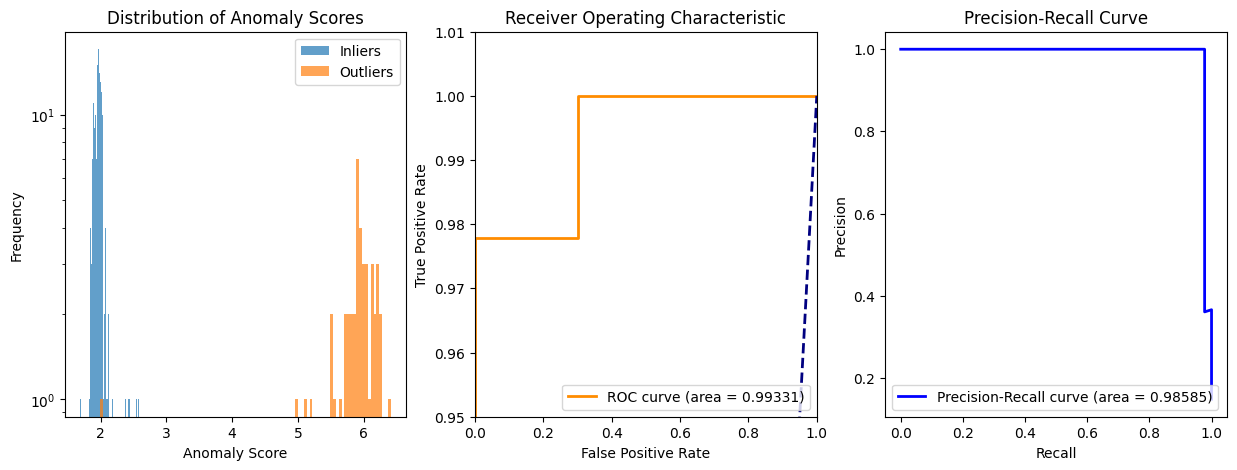

In [13]:
def train_model(model):
  anomaly_rate = 1.0
  metrics_dict = {
      'fpr': {},
      'tpr': {},
      'precision': {},
      'recall': {},
      'accuracy': {}
  }
  supervision_rate = 1.0
  improved_df = df.copy()
  # Sample the Anomaly Rate
  #### Sample out Malicious data such that it would become an outlier
  print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
  improved_df = pd.concat([improved_df[improved_df['Label'] != 'dos_ge_dr'], improved_df[improved_df['Label'] == 'dos_ge_dr'].sample(frac=anomaly_rate, random_state=42)]) 
  print(f'improved_df.shape {improved_df.shape} after Sampling Out')
  ratio = improved_df.loc[improved_df["Label"] != "dos_ge_dr"].shape[0]/ improved_df.loc[improved_df["Label"] == "dos_ge_dr"].shape[0]
  print(f'Ratio of Benign to Anomaly is {ratio} : 1')
  # Dataset
  scaler = StandardScaler()
  Y = improved_df['Label'].map({"dos_ge_dr":1}).fillna(0)
  X = improved_df.copy().drop(columns=["Label"], axis=1)
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

  train_perc = 0.8

  # benign training and testing

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                      Y, 
                                                      test_size = 1-train_perc, 
                                                      shuffle = True, 
                                                      stratify = Y, 
                                                      random_state = 0)
  # Start Training
  idx = np.where(y_train==1)[0]
  y = np.zeros_like(y_train.values)
  if supervision_rate == 0:
    print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
    y[idx[:2]] = 1
  else:
    print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
    idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
    y[idx] = 1
  
  clf = model( device = 'cpu', verbose=1, epochs=10)
  clf.fit(X=X_train.to_numpy(), y = y)
  # pred = clf.predict(X_test.to_numpy())
  anomaly_scores = clf.decision_function(X_test.to_numpy())

  fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
  precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
  opt_threshold = get_optimal_threshold(precision, recall, thresholds)
  pred = np.where(anomaly_scores > opt_threshold, 1,0)
  accuracy = accuracy_score(y_test, pred)
  get_score(pred, y_test)
  
  # Store metrics
  metrics_dict['fpr'][supervision_rate] = fpr
  metrics_dict['tpr'][supervision_rate] = tpr
  metrics_dict['precision'][supervision_rate] = precision
  metrics_dict['recall'][supervision_rate] = recall
  metrics_dict['accuracy'][supervision_rate] = accuracy    
  
  # Separate anomaly scores based on the labels
  plot_graph(anomaly_scores, y_test)
  
  return clf
model = train_model(PReNet)

In [14]:
with open('PReNet_cpu.pkl', 'wb') as file:
    pickle.dump(model, file)

In [15]:

with open('PReNet.pkl', 'rb') as file:
  model = pickle.load(file)
  
score = model.decision_function(X=X_test.to_numpy())
precision, recall, thresholds = precision_recall_curve(y_test, score)

opt_threshold = get_optimal_threshold(precision, recall, thresholds)
pred = np.where(score > opt_threshold, 1,0)
get_score(pred, y_test)
  


NameError: name 'X_test' is not defined

In [29]:
score = model.decision_function(X=df.to_numpy())
precision, recall, thresholds = precision_recall_curve(y_test, score)

opt_threshold = get_optimal_threshold(precision, recall, thresholds)
pred = np.where(score > opt_threshold, 1,0)
get_score(pred, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [304, 1519]

In [30]:
dos_df = pd.read_csv("./Dataset/SimulatedCVE/dos_ge_dr.csv")
dos_df

,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,Fwd IAT Min,PSH Flag Count,Fwd Packets/s,Bwd Header Length
0,64260,78.840674,502,74608,302.591581,134.687615,5882145,66,521000,42628,26050,137.987825,0,56519,74605,0,9185,0.349158,852560
1,64260,303.408920,64240,19999,303.877612,134.932206,6067875,66,538280,44022,26914,137.837331,0,1638,19998,0,9495,1.345767,880440
2,64260,298.099757,64240,20971,324.400761,138.567478,6251450,66,556900,45409,27845,137.669845,0,1538,20970,0,9905,1.327786,908180
3,64260,241.537172,64240,21118,334.267090,148.840225,5100782,60,419140,33363,20957,152.887390,0,5118,21117,0,8298,0.992376,667260
4,64260,139.985616,64240,20787,512.097618,218.140341,2909881,60,221820,16100,11091,180.737950,0,5118,20782,0,6018,0.533555,322000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,501,30.076617,501,21340,1228.650398,642.444395,641835,60,152220,8233,7611,77.958824,0,8279,21339,0,7051,0.356654,164660
228,501,97.672450,64240,14929,391.519708,152.572522,1458152,60,132260,10637,6613,137.083012,0,8279,14928,0,2445,0.442963,212740
229,501,271.015625,64240,4672,396.509437,153.936898,1266185,60,114800,9220,5740,137.330260,0,99,4670,0,2132,1.228596,184400
230,503,132.000000,502,1,0.000000,66.000000,132,66,20,2,1,66.000000,0,0,0,0,0,1.000000,40


In [28]:
df = normalized_df.drop(columns=["Label"])
df

,Init_Win_bytes_forward,Bwd Packets/s,Init_Win_bytes_backward,Flow Duration,Packet Length Std,Average Packet Size,Total Length of Bwd Packets,Bwd Packet Length Min,Fwd Header Length,Total Backward Packets,Total Length of Fwd Packets,Bwd Packet Length Mean,Flow IAT Min,Flow IAT Max,Flow IAT Total,PSH Flag Count,Fwd Packets/s,Bwd Header Length
0,2.628943,0.248549,-0.378265,0.008937,-0.682086,-0.723095,3.970038,0.203325,2.936549,3.701218,2.936565,0.081880,-0.040021,0.019659,0.010073,1.140560,0.275795,3.701218
1,2.628943,1.574680,2.748236,-0.063690,-0.681617,-0.722943,4.109234,0.203325,3.051566,3.837908,3.051583,0.079738,-0.040021,-0.053367,-0.062547,1.196607,1.970954,3.837908
2,2.628943,1.543328,2.748236,-0.062397,-0.674144,-0.720676,4.246815,0.203325,3.175502,3.973912,3.175521,0.077353,-0.040021,-0.053500,-0.061255,1.270734,1.940369,3.973912
3,2.628943,1.209312,2.748236,-0.062202,-0.670551,-0.714269,3.384444,-2.436423,2.258562,2.792729,2.258567,0.294010,-0.040021,-0.048736,-0.061059,0.980193,1.369862,2.792729
4,2.628943,0.609625,2.748236,-0.062642,-0.605790,-0.671051,1.742468,-2.436423,0.945187,1.099989,0.945171,0.690528,-0.040021,-0.048736,-0.061505,0.567976,0.589439,1.099989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,-0.380540,-0.205657,-0.378314,-0.017086,0.992201,0.956648,-0.358943,0.203325,-0.305356,-0.348102,-0.305391,-0.750199,-0.040021,-0.046884,-0.020572,-0.227170,-0.265656,-0.348102
1515,-0.380540,-0.205425,-0.378314,-0.011143,0.958548,0.915981,-0.350738,0.203325,-0.280595,-0.332119,-0.280630,-0.769414,-0.040021,-0.048881,-0.010004,-0.198243,-0.264278,-0.332119
1516,2.628943,-0.214213,2.748236,-0.014503,0.502070,0.448506,-0.418015,0.203325,-0.500911,-0.457924,-0.500949,-0.060588,-0.040021,-0.044964,-0.013363,-0.483179,-0.311293,-0.457924
1517,-0.380540,-0.215784,-0.378314,-0.021668,-0.599482,-0.512172,-0.430226,0.203325,-0.528866,-0.476359,-0.528905,4.547233,-0.040021,-0.043531,-0.020527,-0.517169,-0.317505,-0.476359


## Performance Evaluation

In [8]:
df = normalized_df.copy()

improved_df.shape (1519, 19) Before Sampling Out
improved_df.shape (1305, 19) after Sampling Out
Ratio of Benign to Anomaly is 117.63636363636364 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 1.0
Start Training...
ensemble size: 1
epoch  1, training loss: 2.091083, time: 0.0s
epoch 10, training loss: 0.112695, time: 0.0s
Start Inference on the training data...
Accuracy: 0.9962
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667
[[259   1]
 [  0   1]]
improved_df.shape (1519, 19) Before Sampling Out
improved_df.shape (1305, 19) after Sampling Out
Ratio of Benign to Anomaly is 117.63636363636364 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.5
Start Training...
ensemble size: 1
epoch  1, training loss: 2.110778, time: 0.0s
epoch 10, training loss: 0.069691, time: 0.0s
Start Inference on the training data...
Accuracy: 0.9962
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667
[[259   1]
 [  0   1]]
improved_df.shape (1519, 19) Before Sampling Out
improved_df.shape (1305

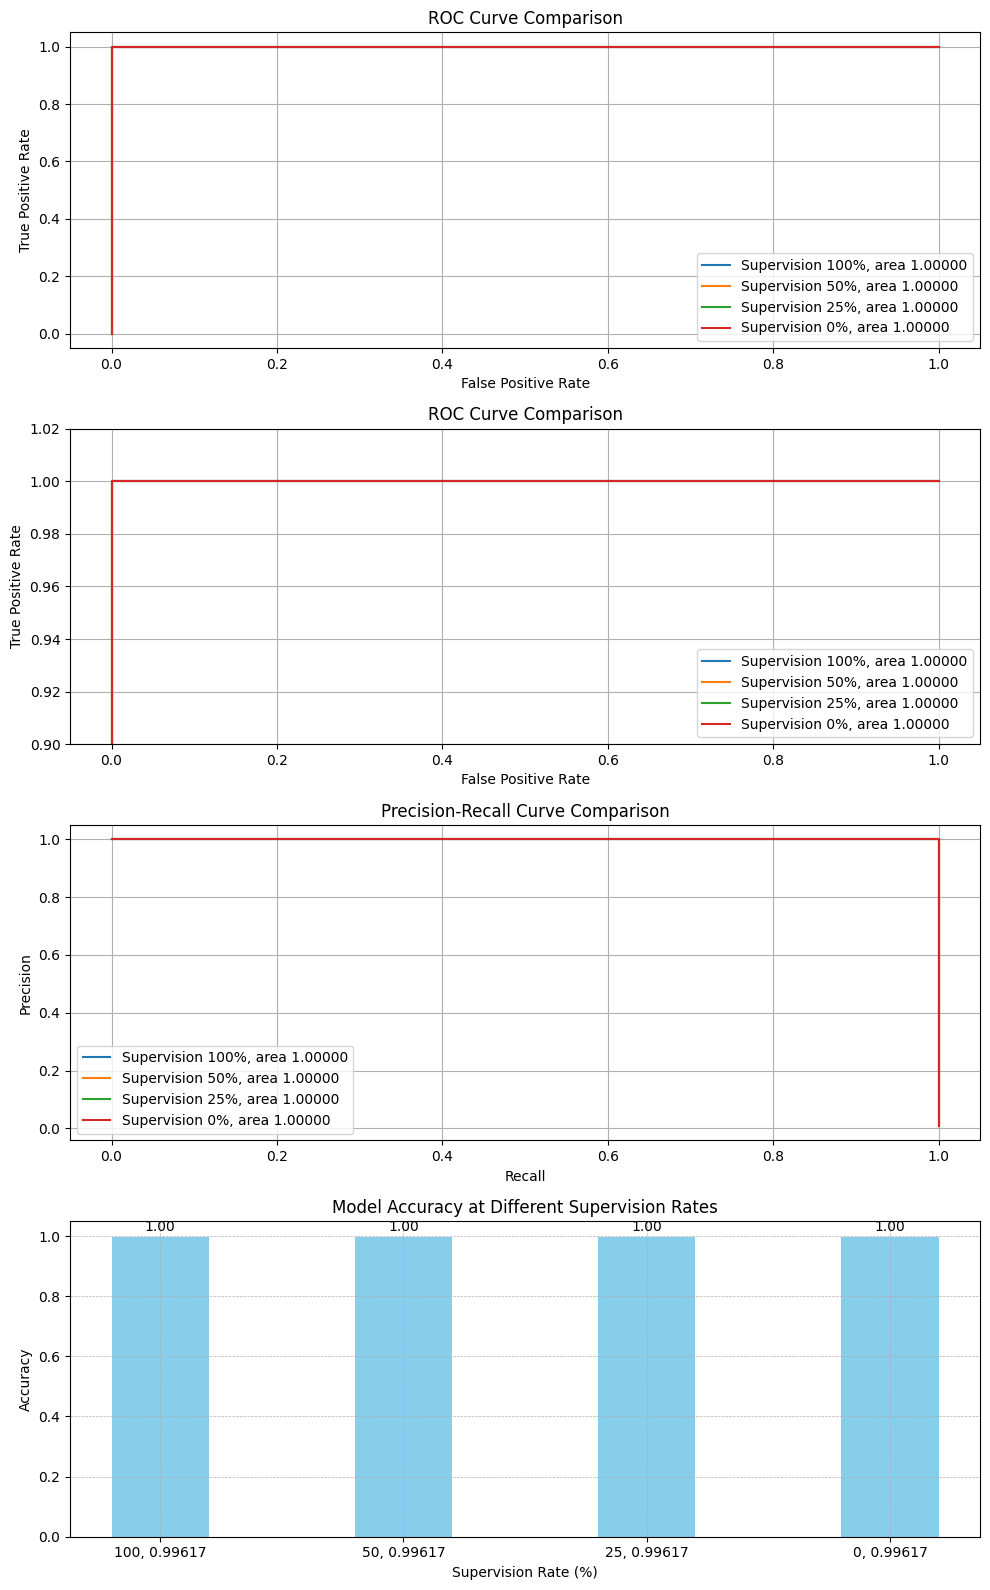

In [32]:
# Read the csv and clean it
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 0.05
  metrics_dict = {
      'fpr': {},
      'tpr': {},
      'precision': {},
      'recall': {},
      'accuracy': {}
  }
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] != 'dos_ge_dr'], improved_df[improved_df['Label'] == 'dos_ge_dr'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] != "dos_ge_dr"].shape[0]/ improved_df.loc[improved_df["Label"] == "dos_ge_dr"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"dos_ge_dr":1}).fillna(0)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.8

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=10)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    
    # Store metrics
    metrics_dict['fpr'][supervision_rate] = fpr
    metrics_dict['tpr'][supervision_rate] = tpr
    metrics_dict['precision'][supervision_rate] = precision
    metrics_dict['recall'][supervision_rate] = recall
    metrics_dict['accuracy'][supervision_rate] = accuracy    
    
    # Separate anomaly scores based on the labels
  # plot_graph(anomaly_scores, y_test[:1000])
  plot_comparison_graph(metrics_dict, supervision_rate_list)

anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.5, 0.25, 0.1, 0.05, 0]
supervision_rate_list = [1.0, 0.5, 0.25,0]


model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


## Save Model

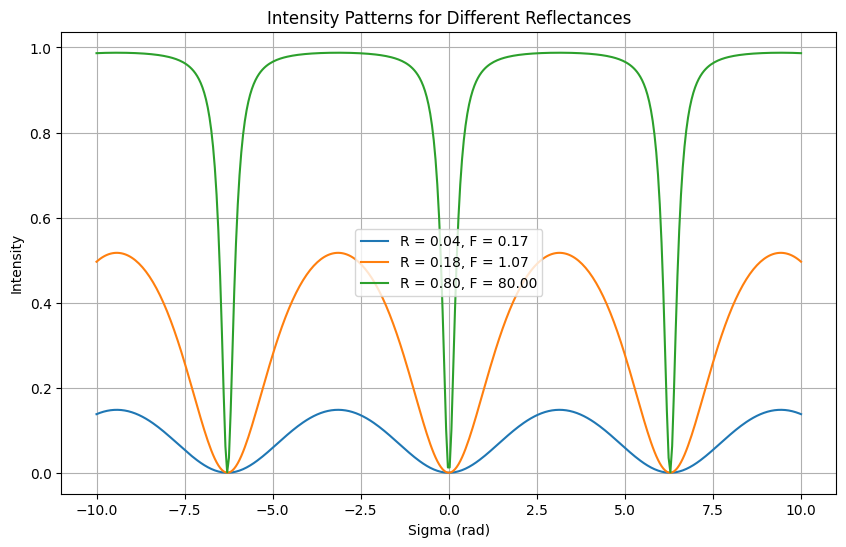

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Reflectance values and derived Fresnel coefficient
R = np.array([0.04, 0.18, 0.8])
F = (4 * R) / ((1 - R)**2)

# Range of sigma values
sigma = np.linspace(-10, 10, 400)

# Plot setup
plt.figure(figsize=(10, 6))

for i, f in enumerate(F):
    # Intensity calculation using the Fresnel equation
    intensity = (f * (np.sin(sigma / 2))**2) / (1 + f * (np.sin(sigma / 2))**2)
    # intensity = (4 * r * (np.sin(sigma / 2))**2) / ((1-r)**2 + (4 * r * np.sin(sigma / 2))**2)
    
    # Plotting each reflectance's intensity profile
    plt.plot(sigma, intensity, label=f'R = {R[i]:.2f}, F = {f:.2f}')

plt.title('Intensity Patterns for Different Reflectances')
plt.xlabel('Sigma (rad)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()


[[1.53721058 2.01293463 2.94433753 ... 2.94433753 2.01293463 1.53721058]
 [2.01293463 2.95064013 4.4989176  ... 4.4989176  2.95064013 2.01293463]
 [2.94433753 4.4989176  5.63947519 ... 5.63947519 4.4989176  2.94433753]
 ...
 [2.94433753 4.4989176  5.63947519 ... 5.63947519 4.4989176  2.94433753]
 [2.01293463 2.95064013 4.4989176  ... 4.4989176  2.95064013 2.01293463]
 [1.53721058 2.01293463 2.94433753 ... 2.94433753 2.01293463 1.53721058]]
[[2.37914703 2.92543054 3.82183933 ... 3.82183933 2.92543054 2.37914703]
 [2.92543054 3.8272629  4.96582329 ... 4.96582329 3.8272629  2.92543054]
 [3.82183933 4.96582329 5.63954275 ... 5.63954275 4.96582329 3.82183933]
 ...
 [3.82183933 4.96582329 5.63954275 ... 5.63954275 4.96582329 3.82183933]
 [2.92543054 3.8272629  4.96582329 ... 4.96582329 3.8272629  2.92543054]
 [2.37914703 2.92543054 3.82183933 ... 3.82183933 2.92543054 2.37914703]]
[[3.27639422 3.78284244 4.49107799 ... 4.49107799 3.78284244 3.27639422]
 [3.78284244 4.4949832  5.23760741 ... 

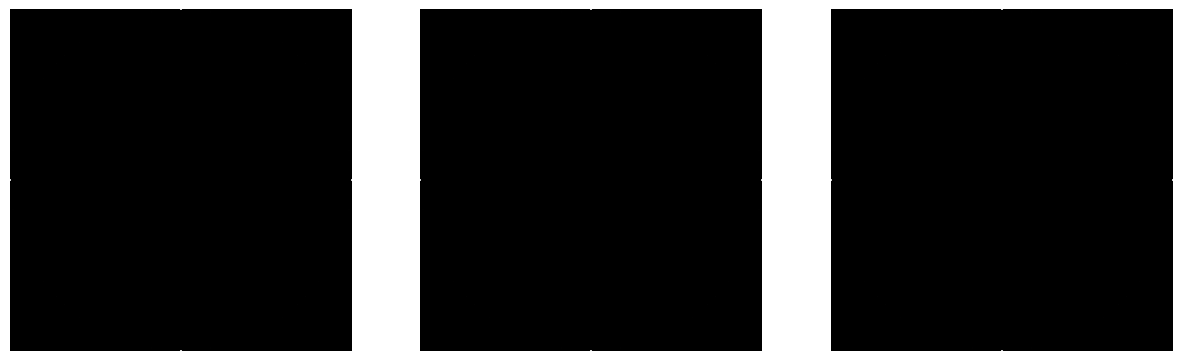

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 0.05  # Absorption coefficient
R = 0.04  # Reflectance
F = 3.0   # Finesse of the optical setup

# Create a 2D grid
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)  # Radial distance from the center

# Assuming delta varies with the radial distance such that delta = k * R
# Where k is some scaling factor to adjust the appearance of fringes
k = 50 * np.pi
delta = k * R

# Calculate the transmitted intensity ratio using the interference formula
It_Ii = (1 - ( A / (1 - R)))**2 * (1 / (1 + F * np.sin(delta / 2)**2))

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    if i == 0:  # High finesse
        F_mod = F
    elif i == 1:  # Moderate finesse
        F_mod = F / 2
    else:  # Low finesse
        F_mod = F / 4
    
    It_Ii_mod = ((1 - A) / (1 - R))**2 * (1 / (1 + F_mod * np.sin(delta / 2)**2))
    ax.imshow(It_Ii_mod, cmap='gray', extent=(-1, 1, -1, 1))
    ax.axis('off')  # Hide the axes

plt.show()


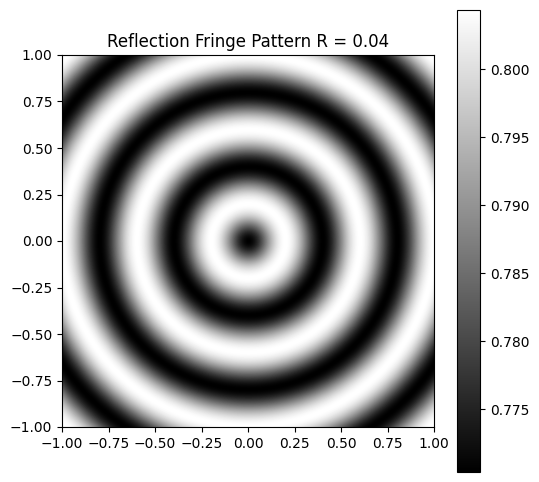

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 0.5  # Absorption coefficient
R = 0.04  # Reflectance
F = (4 * R) / ((1 - R)**2)

# Create a 2D grid
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
radius = np.sqrt(X**2 + Y**2)  # Radial distance from the center

# Adjust k to a smaller value if needed
k = 5 * np.pi
delta = k * radius

# Ensure delta does not lead to extreme values in sin function
# delta = np.mod(delta, 2*np.pi)  # Normalize delta to be within one full phase cycle (0 to 2*pi)

# Calculate the transmitted intensity ratio using the interference formula
It_Ii = 1-(1 - ( A / (1 - R)))**2 * (1 / (1 + F * np.sin(delta / 2)**2))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(It_Ii, cmap='gray', extent=(-1, 1, -1, 1))
plt.colorbar()  # To see the range of values
plt.title(f"Reflection Fringe Pattern R = {R}")
plt.axis('on')  # Hide the axes
plt.show()


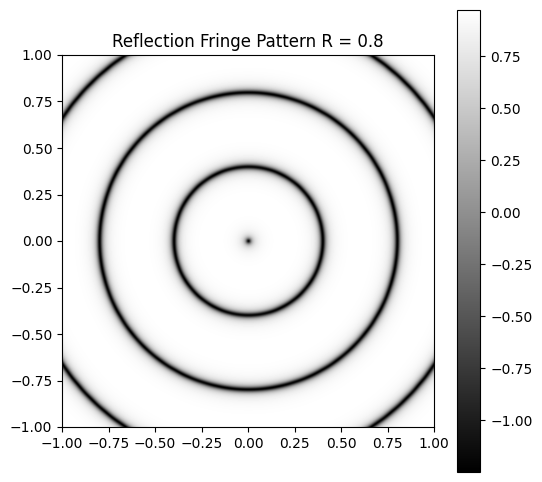

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 0.5  # Absorption coefficient
R = 0.8  # Reflectance
F = (4 * R) / ((1 - R)**2)

# Create a 2D grid
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
radius = np.sqrt(X**2 + Y**2)  # Radial distance from the center

# Adjust k to a smaller value if needed
k = 5 * np.pi
delta = k * radius

# Ensure delta does not lead to extreme values in sin function
# delta = np.mod(delta, 2*np.pi)  # Normalize delta to be within one full phase cycle (0 to 2*pi)

# Calculate the transmitted intensity ratio using the interference formula
It_Ii = 1-(1 - ( A / (1 - R)))**2 * (1 / (1 + F * np.sin(delta / 2)**2))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(It_Ii, cmap='gray', extent=(-1, 1, -1, 1))
plt.colorbar()  # To see the range of values
plt.title(f"Reflection Fringe Pattern R = {R}")
plt.axis('on')  # Hide the axes
plt.show()
